## Susannah D'Arcy

For this notebook I will analyze the relationships between tech Twitter accounts, by generating networks for their follows, mentions and replies. I will also look into the topics they share by creating a network of their hashtags.

## 1.0 Pre Construction and Analysis of Networks

### 1.1 Access Data: Members
For easy access of all my Twitter List Members I will create a dictionary which will hold relevant and possibly interesting information. I also will generate a simple list which will hold all of the screens names of the members in my twitter list, for quick reference checking.

In [1]:
import json
with open("list_members.jsonl","r") as membersFile:
    list_members = list(membersFile)

members = {}
membersNames = []
for member in list_members:
    data = json.loads( member )
    mem = {
        "name": data["name"],
        "id": data["id"],
        "location": data["location"]
    }
    members[data["screen_name"]] = mem
    membersNames.append(data["screen_name"])

print(len(members), "Twitter Users in our List")
print(membersNames)

27 Twitter Users in our List
['verge', 'futureshift', 'VentureBeat', 'CNET', 'WSJTech', 'ReutersTech', 'technology', 'TelegraphTech', 'usatodaytech', 'techradar', 'ForbesTech', 'engadget', 'fttechnews', 'thenextweb', 'guardiantech', 'TechRepublic', 'RWW', 'ZDNet', 'gigaom', 'Gizmodo', 'WIRED', 'mashable', 'CNETNews', 'Techmeme', 'TechCrunch', 'arstechnica', 'BBCTech']


### 1.2 Access Data: Tweets
From the Tweets json list file I will create a list of jsons. Which I will use later create networks. 

In [2]:
with open("tweets.jsonl","r") as tweetFile:
    tweet_list = list(tweetFile)

for tweet in tweet_list:
    data = json.loads( tweet )

### 1.3 Characterisation Functions
For all my networks in this report I will be doing a similar analysis. I will look into the structure, clustering and reciprocity for the connectivity and relationships within my network. Degree and Degree distribution will show popular nodes, and the pattern of connections of my network. Lastly centrality will identity influential nodes. Before I begin any of my characterisation I will create functions which allow me to not have to repeat code, and have a consistent analysis output. I've decided to use pandas dataframes to hold the results of my characterisation functions as they allow you to display multiple results, in an easy to understand matter, they allow have statistic functions. For each of the dataframes I will sort them based on each of the different characterisations, (ie for each of the centralities), as comparing them can provide insight on their influence on the network.

For each function I will also return the dataframes for any further analysis. 

In [4]:
import networkx as nx
import pandas as pd
from networkx.algorithms import bipartite
pd.set_option("display.precision", 3)
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

#### 1.3.1 Visualisation Functions
I created these functions to keep my visualisation consistent, and so I will not have to repeat my code. For each dataframe we create I thought it would be interesting to see the top 5 results, and the bottom 3. From this we can compare the difference of each analysis and see any patterns.

In [5]:
'''
Function to draw networks using nx.draw, with a default big drawing
- G: Graphs/network to be drawn 
- sizeX: width of drawing. Default 20
- sizeY: height of drawing. Default 10
'''
def displayNetwork(G, sizeX=20, sizeY = 10):
    pos = nx.drawing.circular_layout(G)
    plt.figure(figsize=(sizeX,sizeY))
    
    #Have a big drawing to large networks, and no labels, as this will clutter the drawing.
    if len(G.nodes) > 30:
        plt.figure(figsize=(20,10))
        nx.draw_networkx(G, pos=pos, with_labels=False, node_size = 500, font_size = 12)
    else:
        plt.figure(figsize=(sizeX,sizeY))
        nx.draw_networkx(G, pos=pos, with_labels=True, node_size = 500, font_size = 12)
        #draw edges weights for small networks.
        if nx.is_weighted(G):
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G,pos=pos,edge_labels=labels)
    plt.show()     
    print("Nodes: %d, Edges: %d" %  (G.number_of_nodes(), G.number_of_edges()))

'''
Function to display the top 5, and last 3 entries for my dataframes
- df: Dataframe to display
- sortby: the column to sort the whole dataframe.
'''
def displayDF(df, sortby):
    display(df.sort_values(by=sortby, ascending=False).head(5))
    display(df.sort_values(by=sortby, ascending=False).tail(3))

#Function to manipluate the HTML to display my dataframes side by side for easier viewing    
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


'''
Function of display the distribution of a given series:
- Series: the inputted series we want to find the distribution of
- labels: the labels for each distribution histogram
- subplot: the amount of histogram we want in each display, default 1. Max 2
'''
def plotDist(series, labels, subplot = 1):
    if subplot == 2:
        #2 plots side by side
        fig, axs = plt.subplots(1,2)
        for i in range(subplot):
            df = series[i].plot.hist(figsize=(12,6), fontsize=14, legend=None, color="darkred", bins=50, zorder=3, ax=axs[i])        
            df.yaxis.grid()
            df.set_ylabel("Number of Nodes", fontsize=14)
            df.set_xlabel(labels[i], fontsize=14)
    else:
        #display histogram
        df = series[0].plot.hist(figsize=(12,6), fontsize=14, legend=None, color="darkred", bins=50, zorder=3)        
        df.yaxis.grid()
        df.set_ylabel("Number of Nodes", fontsize=14)
        df.set_xlabel(labels[0], fontsize=14)


#### 1.3.2 getStructure Function
To repersent the structure of each network I will look into its desnity, and its connected status.

##### Density
A network density expresses the amount of connections within the network, if the network were to be dense, the amount of edges would be close to the potential edges. Thus a higher dense network would mean that the network would have a high connectivity.

##### Connected 
For undirected networks, it will be described as connected if every node has a path to every other node. For directed networks, its described as strongly connected if every node has a path to every other node in the network. Weakly connected is when if we were to convert each direct edge to undirected, would we have an connected network. If they are not connected we can calculate the number of subgraphs which are connected (strongly or weakly), these are called components.

If we have a connected graph we can also calculate the average shortest path and the diameter. This will express how closely connected our network is, and thus its connectivity.

In [6]:
'''
Function to understand the structure of a given network G
- G: Network
- nodes: Nodes to include for Bipartite networks, default is None. 
'''
def getStructure(G, nodes=None):
    #Density
    #Bipartite has a different density function
    if bipartite.is_bipartite(G): 
        d = bipartite.density(G,nodes) 
    else:
        d = nx.density(G)
    print("Network's Density: %.2f" %d)
    
    #Connection and Components
    if nx.is_directed(G):
        if nx.is_strongly_connected(G):
            print("Network is strongly connected, there are no sub components.")
            #Diameter can only be done on strongly connected graphs
            print("Network's Diameter", nx.diameter(G))
        else:
            print("Network is not strongly connected, there are", nx.number_strongly_connected_components(G), "components.")
        
        if nx.is_weakly_connected(G):
            print("Network is weakly connected, there are no sub components.")
            #Average Shortest Path can only be calcluated on weakly connected graphs
            print("Network's Average Shortest Path: %.2f" %nx.average_shortest_path_length(G))
        else:
            print("Network is not weakly connected, there are", nx.number_weakly_connected_components(G), "components.")
            
    else:    
        if nx.is_connected(G):
            print("Network is connected, there are no sub components.")
            #Diameter
            print("Network's Diameter", nx.diameter(G))
        else:
            print("Network is not connected, there are", nx.number_connected_components(G), "components.") 

#### 1.3.3 Clustering and Reciprocity Functions
##### Clustering Coefficient
Clustering Coefficient is used to express whether a node shares neighbours with its neighbours, creating a close triad structure. With this we can identify any subgroups in our networks, such as a group of nodes who follow each other, or similar topics of hashtags.
##### Reciprocity
Reciprocity for directed graphs is when is a pair of nodes have 2 edges between then, thus forming a reciprocal path (with possibly 2 different weights). These can be used to express the percentage of nodes which follow/reply/mention each other. If we have some reciprocity, we can create a reciprocity network which converts all reciprocal edges into undirected edges and remove any non-reciprocal edges. This will show any strong relationships in our networks.

In [7]:
'''
Function to get the Clustering Coefficient of a given network G
- G: Network
- nodes: Nodes to include for Bipartite networks, default is None. 
'''
def getClustering(G, nodes=None):
    #Bipartite has a different cluserting function
    if bipartite.is_bipartite(G): 
        if nodes:
            #Compute clusting for group of nodes
            clustering = pd.Series(dict(bipartite.clustering(G,nodes)), name="clustering")
        else:
            #Compute clusting for all the nodes
            clustering = pd.Series(dict(bipartite.clustering(G)), name="clustering")
    else:
        clustering = pd.Series(dict(nx.clustering(G)), name="clustering")
    displayDF(pd.DataFrame(clustering), "clustering")

#Function to get the Reciprocity percentage of a given network G, and the pairs of reciprocal nodes
def getReciprocity(G):
    print("Reciprocity %.2f" % nx.reciprocity(G) )  
    # check all unique pairs to look for reciprocity
    for pair in itertools.combinations(G.nodes(), r=2):
        if G.has_edge( pair[0], pair[1] ) and G.has_edge( pair[1], pair[0] ):
            print( "%s <--> %s" % pair )

#Function to convert given network G into a Reciprocal Network, and draw the new graph.         
def getReciprocalNetwork(G):
    print("Before: Nodes: %d Edges: %d" %(G.number_of_nodes(), G.number_of_edges()))
    #Convert to Reciprocal Network
    rG = G.to_undirected( reciprocal=True )
    #Remove Isolated Nodes, only print them if there isnt too many 
    if len(list(nx.isolates(rG))) < 10:
        print("Isolated Nodes: ", list(nx.isolates(rG)))    
    rG.remove_nodes_from(list(nx.isolates(rG)))
    #Remove self-loop Nodes
    selfLoopNodes = list(rG.nodes_with_selfloops())
    toKeep = []
    for node in selfLoopNodes:
        if len(rG.edges(node)) > 1:
            toKeep.append(node)
    for node in toKeep:
        selfLoopNodes.remove(node)
    rG.remove_nodes_from(selfLoopNodes)

    print("After: Nodes: %d Edges: %d" %(rG.number_of_nodes(), rG.number_of_edges()))
    displayNetwork(rG)
    return rG

#### 1.3.4 Degree Functions

##### Degree
Degree is the number of edges a node has, therefore it can describe how popular a node is. For directed networks we have in-degree, which is the amount of edges connecting into the node. In-degree can express the popularity of the network. We also have out-degree which is the amount of edges coming out of the node. This can show the activity of the node. I will be calculating the degree centrality. Degree centrality normalises the degree score which makes it much easier to compare networks.

##### Weighted Degree Centrality
For each degree we can include the weights or not, which can show the difference in the number of unique connections (non weighted), and the amount of total connections (weighted). There is however no weighted degree centrality function, therefore I made my own, by gather each of the weighted degrees, and normalising them by the total weighted degree the network.

#####  Degree Distribution
Distribution allows you to see the trends and variance of values in our network. We calculate the frequency of each degree, and use this to make an histogram. This will allow us to gain some insights into the amount and frequency of connections each node in our network has.

In [8]:
#Function to calculate the weighted degree centrality for a given network G
def getWeightedDegreeCent(G):   
    #Weighted in-degree and out-degree for directed networks
    if nx.is_directed(G):
        inDegreeCent = {}
        outDegreeCent = {}
    #Sum of degrees
        sumIN = 0
        sumOUT = 0
        for key in dict( G.in_degree(weight="weight")):
            sumIN += G.in_degree(key, weight="weight")
        for key in dict( G.out_degree(weight="weight")):
            sumOUT += G.out_degree(key, weight="weight")
        #Get Centrality by normalising each degree.   
        for key in dict( G.in_degree(weight="weight")):
            inDegreeCent[key] =(G.in_degree(key, weight="weight")/sumIN)
        for key in dict( G.out_degree(weight="weight")):
            outDegreeCent[key] =(G.out_degree(key, weight="weight")/sumOUT)   
            
        return [inDegreeCent, outDegreeCent]  
    else:
        degreeCent = {}  
        #Sum of degrees
        sum = 0
        for key in dict( G.degree(weight="weight")):
            sum += G.degree(key, weight="weight")
        #Get Centrality  
        for key in dict( G.degree(weight="weight")):
            degreeCent[key] =(G.degree(key, weight="weight")/sum)
        return degreeCent
       
#Function to calculate the degree centrality for any given network  G 
def getDegreeCent(G):
    #Need to cacluate different degrees for directed vs non-directed and weight vs non-weighted networks
    if nx.is_directed(G):
        if nx.is_weighted(G):
            in_degree_cent = pd.Series(getWeightedDegreeCent(G)[0], name="in_degree_centrality_weighted")
            out_degree_cent = pd.Series(getWeightedDegreeCent(G)[1], name="out_degree_centrality_weighted")
          
            degreeDF = pd.concat([in_degree_cent, out_degree_cent], axis=1)
            print("Sorted by weighted in degree centrality")
            displayDF(degreeDF, "in_degree_centrality_weighted")
            print("Sorted by weighted out degree centrality")
            displayDF(degreeDF, "out_degree_centrality_weighted")
                   
        else: 
            in_degree_cent = pd.Series(dict(nx.in_degree_centrality(G)), name="in_degree_centrality")
            out_degree_cent = pd.Series(dict(nx.out_degree_centrality(G)), name="out_degree_centrality")

            degreeDF = pd.concat([in_degree_cent, out_degree_cent], axis=1)
            degreeDF.name = "Sorted by in degree centrality"
            degreeDF = degreeDF.sort_values(by="in_degree_centrality", ascending=False)
            degreeDF2 = degreeDF.sort_values(by="out_degree_centrality", ascending=False)
            degreeDF2.name = "Sorted by out degree centrality"
 
            print("Sorted by in degree centrality")
            #displayDF(degreeDF, "in_degree_centrality")
            print("Sorted by out degree centrality")
            #displayDF(degreeDF, "out_degree_centrality")
            
            display_side_by_side(degreeDF,degreeDF2) 
            return [degreeDF, degreeDF2]
    else:
        if nx.is_weighted(G):
            degree_cent = pd.Series(getWeightedDegreeCent(G), name="degree_centrality_weighted")
            displayDF(pd.DataFrame(degree_cent), "degree_centrality_weighted")
        else:
            degree_cent = pd.Series(dict(nx.degree_centrality(G)), name="degree_centrality")
            displayDF(pd.DataFrame(degree_cent), "degree_centrality")    
        return pd.DataFrame(degree_cent)
       
#Function to display the degree distribution for a given network G.       
def getDegreeDistribution(G):     
    #Different distribution for directed vs non-directed and weighted vs non-weighted networks
    if nx.is_directed(G):
        if nx.is_weighted(G):
            in_degree = pd.Series(dict(G.in_degree(weight='weight')))
            out_degree = pd.Series(dict(G.out_degree(weight='weight')))
            plotDist([in_degree, out_degree], ["Weighted In Degree", "Weighted Out Degree"], 2)
        else:
            in_degree = pd.Series(dict(G.in_degree()))
            out_degree = pd.Series(dict(G.out_degree()))
            plotDist([in_degree, out_degree], ["In Degree", "Out Degree"], 2)
    else:
        if nx.is_weighted(G):
            degree_weight = pd.Series(dict(G.degree(weight='weight')))
            degree = pd.Series(dict(G.degree()))
            plotDist([degree, degree_weight], ["Degree", "Weighted Degree"], 2)
        else:
            degree = pd.Series(dict(G.degree()))
            plotDist([degree], ["Degree"])

#### 1.3.5 Centrality Function
For each network we will want to gather the centrality. This will allow us to identify influential nodes in our networks.

##### Betweenness Centrality
Betweenness can identify important nodes to the network as they represent nodes which occur on many of the other nodes shortest paths. These nodes can be called brokers or bridging nodes, and they represent key strategic linkages between all nodes in the system.

Nodes with high betweenness have a large influence on the network as they control the flow of information between all nodes. If you were to remove these nodes it could disrupt the connectivity of the whole network.

To calculate you take every pair of the network and count how many times a node can interrupt the shortest paths between the two nodes of the pair. We then normalise it to get the centrality.

##### Closeness Centrality
Closeness as the name suggests measure a nodes closeness to all other nodes in the network through direct or indirect connections. It's calculated by inverting the average distance of the node to all other nodes, and distance is the shortest path between 2 nodes.

We use closeness to represent a node’s ability to access information through its connections or the ‘grape vine'.

##### Eigenvector Centrality
Eigenvector centrality which uses all of the other centralities for its calculation. The eigenvector centrality of a node is proportional to the sum of the centrality scores of its neighbours. Which means that if a node was connected to an influential node it will also be important.

Eigenvector also takes into consideration that it's better to be connected to a small amount of important nodes, then connected to a large number of median influence nodes.

For weighted networks we can also consider the weighted eigenvector, which will be effected by the weights of each edge in the network.

I will place all of these into one dataframe, so for each node we can compare its centralities. I will however display the dataframe sorted by each centrality, so we can see the top and bottom results of each one.

In [9]:
'''
Function to calcluate all of the centralities for any given network G
- G: Network
- nodes: Nodes to include for Bipartite networks, default is None. 
'''
def getCentrality(G, nodes=None):
    #Bipartite has different centrality functions
    if bipartite.is_bipartite(G):   
        #Centrality based on User Nodes
        degree = pd.Series(dict(bipartite.degree_centrality(G, nodes)), name="degree_centrality")
        between = pd.Series(dict(bipartite.betweenness_centrality(G, nodes)), name="betweenness_centrality")
        closeness = pd.Series(dict(bipartite.closeness_centrality(G, nodes)), name="closeness_centrality")
        
        centralityDF = pd.concat([degree, between, closeness], sort=True, axis=1)
        
        #Display df sorted by each centrality
        print("Sorted by degree centrality")
        displayDF(centralityDF, "degree_centrality")
        print("Sorted by betweenness centrality")
        displayDF(centralityDF, "betweenness_centrality")
        print("Sorted by closeness centrality")
        displayDF(centralityDF, "closeness_centrality")
    else:
        #Calcluate Centrality
        between = pd.Series(dict(nx.betweenness_centrality(G)), name="betweenness_centrality")
        closeness = pd.Series(dict(nx.closeness_centrality(G)), name="closeness_centrality")
        eigenvector = pd.Series(dict(nx.eigenvector_centrality(G)), name="eigenvector_centrality")
        
        #Include weighted eigenvector for weighted networks.
        if nx.is_weighted(G):
            eigenvector_weighted = pd.Series(dict(nx.eigenvector_centrality(G, weight="weight")), name="eigenvector_centrality_weighted")
            centralityDF = pd.concat([eigenvector, eigenvector_weighted, between, closeness], axis=1)
        else:
            centralityDF = pd.concat([eigenvector, between, closeness], axis=1)
    
        #Display df sorted by each centrality
        print("Sorted by eigenvector centrality")
        displayDF(centralityDF, "eigenvector_centrality")
        if nx.is_weighted(G):
            print("Sorted by weighted eigenvector centrality")
            displayDF(centralityDF, "eigenvector_centrality_weighted")
        print("Sorted by betweenness centrality")
        displayDF(centralityDF, "betweenness_centrality")
        print("Sorted by closeness centrality")
        displayDF(centralityDF, "closeness_centrality")
        
    return centralityDF

## 2.0 Follower network
A follower network represents the follower to followee relationship in our Twitter social network. For this we will see which Twitter list members follow each other. From analysing follower networks we can see any possible influencers depicted by their in-degree popularity. Or possibly we can identify close clusters of subgroups within our list.

### 2.1 Construction
The network will be a directed non-weighted graph, as following is not always a two-way relationship, and there aren't degrees following, or you cannot follow someone multiple times, thus the edges are unweighted.

I will use the friendships.csv as my edges for my followers network. I can use read_edgelist function to do this easily. This will also make nodes for each of my list members (if they follow (or are followed) a fellow list member).

In [10]:
#Read file, create edges which creates the nodes for each user.
followG = nx.read_edgelist("friendships.csv", delimiter = "\t", create_using=nx.DiGraph)

followG.number_of_nodes(), followG.number_of_edges()

(27, 155)

C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


<Figure size 1440x720 with 0 Axes>

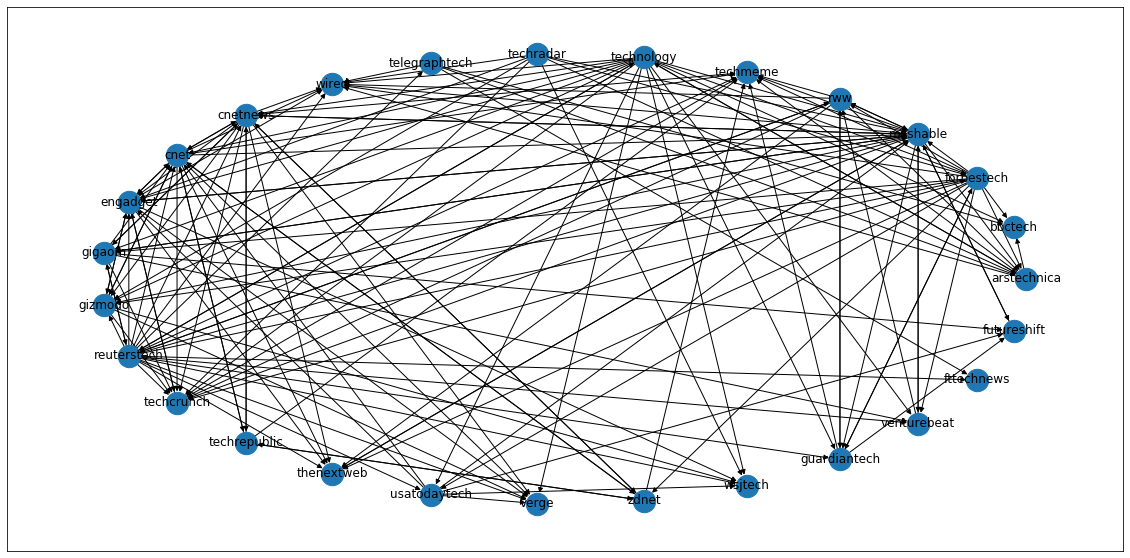

Nodes: 27, Edges: 155


In [11]:
displayNetwork(followG)

### 2.2 Characterisation 

#### 2.2.1 Structure

In [12]:
getStructure(followG)

Network's Density: 0.22
Network is not strongly connected, there are 8 components.
Network is weakly connected, there are no sub components.
Network's Average Shortest Path: 1.59


We can see that our follow network is not very connected with a density of 0.22, which means that out of all possible edges we only have 22% of them in our follow network. However the average shortest path is 1.59, which suggest that of those sub networks which are connected, they are close as we have a small shortest path.

Our network is not strongly connected which means that every node does not have a path to every other node in its network. Lets look at structure of our largest connected component subgraphs.

<Figure size 720x360 with 0 Axes>

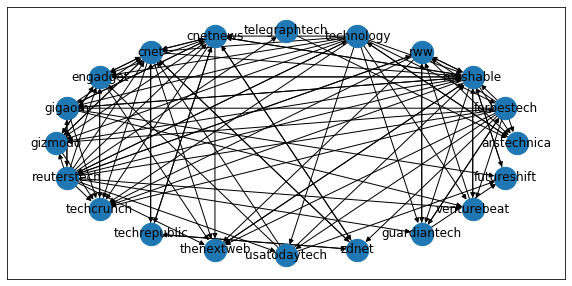

Nodes: 20, Edges: 108


<Figure size 720x360 with 0 Axes>

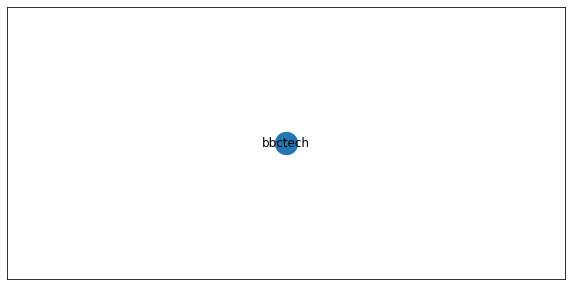

Nodes: 1, Edges: 0


<Figure size 720x360 with 0 Axes>

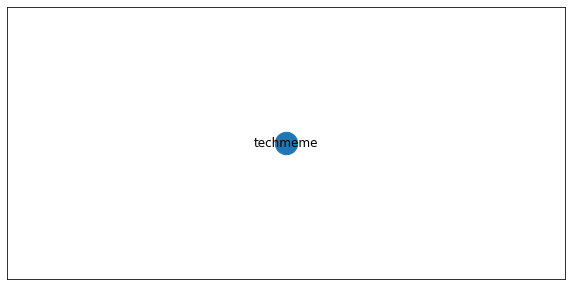

Nodes: 1, Edges: 0


In [13]:
limit = 1
for graph in sorted(nx.strongly_connected_component_subgraphs(followG), key=len, reverse=True):
    if limit > 3:
        break
    displayNetwork(graph, sizeX=10, sizeY=5)      
    limit += 1

In [14]:
print("bbctech: out-degree %d in-degree: %d" %(followG.out_degree("bbctech"), followG.in_degree("bbctech")))
print("techmeme: out-degree %d in-degree: %d" %(followG.out_degree("techmeme"), followG.in_degree("techmeme")))

bbctech: out-degree 0 in-degree: 4
techmeme: out-degree 0 in-degree: 11


From looking at the top 3 largest subgraphs, and the 2nd and 3rd graphs out-degree, we can see that 7 of our subgraphs are simply nodes which do not follow anyone as they have no out-degree and thus they do not have a path to any other node in our network.

#### 2.2.2 Clustering

In [15]:
getClustering(followG)

clustering
techrepublic       0.833
venturebeat        0.625
zdnet              0.620
verge              0.571
thenextweb         0.556

clustering
reuterstech         0.256
forbestech          0.227
telegraphtech       0.200

In [16]:
print(list(followG.neighbors("techrepublic")))

for n1 in followG.neighbors("techrepublic"):
    for n2 in followG.neighbors("techrepublic"):
        if followG.has_edge(n1,n2):
            print("Yes:", n1, n2)
    print("\n")

['cnet', 'cnetnews', 'techmeme', 'zdnet']
Yes: cnet cnetnews
Yes: cnet techmeme
Yes: cnet zdnet


Yes: cnetnews cnet
Yes: cnetnews techmeme
Yes: cnetnews zdnet




Yes: zdnet cnet
Yes: zdnet cnetnews
Yes: zdnet techmeme




Techrepublic has the highest clustering which means a majority of techrepublic followers also follow each other.

Further looking into techrepublic's neighbours, we can see that cnet, cnetnews and zdnet are closely connected and follow each other, while techmeme doesn’t follow any of them. This shows that techrepublic, cnet, cnetnews and zdnet have a strong relationship.

#### 2.2.3 Reciprocity

In [17]:
getReciprocity(followG)

Reciprocity 0.31
arstechnica <--> technology
forbestech <--> guardiantech
mashable <--> rww
mashable <--> cnetnews
mashable <--> engadget
mashable <--> gigaom
mashable <--> thenextweb
mashable <--> venturebeat
mashable <--> futureshift
rww <--> reuterstech
rww <--> guardiantech
technology <--> reuterstech
cnetnews <--> cnet
cnetnews <--> gigaom
cnetnews <--> techrepublic
cnetnews <--> zdnet
cnet <--> engadget
cnet <--> gizmodo
cnet <--> techrepublic
cnet <--> zdnet
engadget <--> gizmodo
engadget <--> techcrunch
gigaom <--> reuterstech
techrepublic <--> zdnet


From the Reciprocity we can see that only a 3rd of our members follow each other. Which shows that the technology network is not closely connected only and we might have groupings of close nodes instead of the network as a whole having a strong connection. 

Before: Nodes: 27 Edges: 155
Isolated Nodes:  ['bbctech', 'techmeme', 'techradar', 'telegraphtech', 'wired', 'usatodaytech', 'verge', 'wsjtech', 'fttechnews']
After: Nodes: 18 Edges: 24


C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<Figure size 1440x720 with 0 Axes>

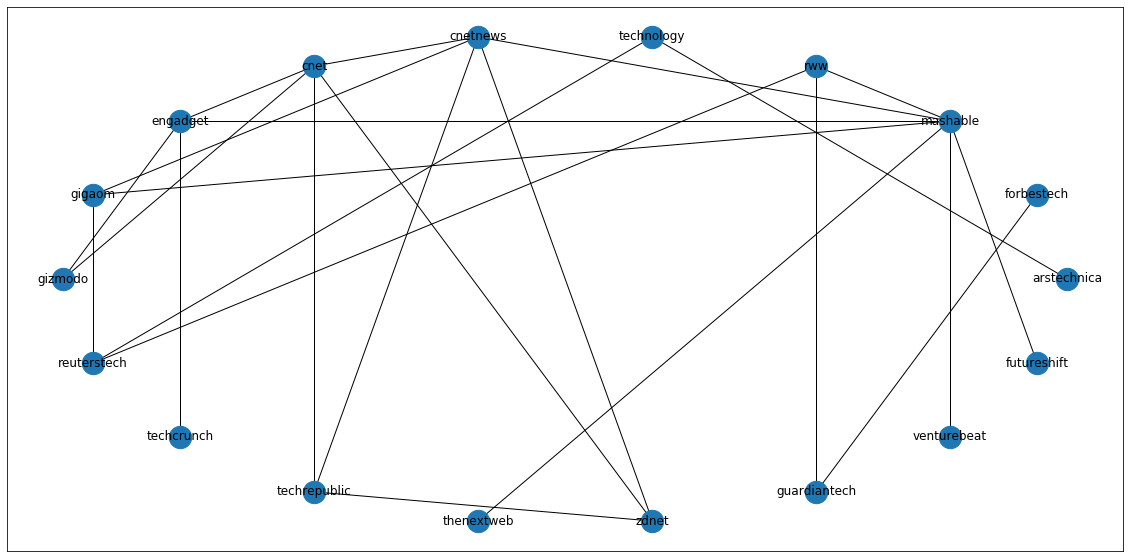

Nodes: 18, Edges: 24


In [18]:
follow_reciprocal = getReciprocalNetwork(followG)

From here we can visually see the reciprocal nodes in our network, from this we can see have mashable has a high reciprocity, which suggest that mashable possibly has a follow for follow system.

#### 2.2.4 Degree Centrality and Degree Distribution

In [19]:
follow_degree_cent_DF = getDegreeCent(followG)

print("Mean: \n", follow_degree_cent_DF[0].mean())
print("Min: \n",follow_degree_cent_DF[0].min())
print("Max: \n",follow_degree_cent_DF[0].max())

Sorted by in degree centrality
Sorted by out degree centrality


in_degree_centrality 
 out_degree_centrality 
 
 
 
 
 mashable 
 0.500 
 0.500 
 
 
 techmeme 
 0.423 
 0.000 
 
 
 wired 
 0.423 
 0.000 
 
 
 techcrunch 
 0.423 
 0.077 
 
 
 cnet 
 0.346 
 0.423 
 
 
 engadget 
 0.346 
 0.308 
 
 
 gizmodo 
 0.308 
 0.192 
 
 
 verge 
 0.269 
 0.000 
 
 
 thenextweb 
 0.269 
 0.038 
 
 
 cnetnews 
 0.269 
 0.462 
 
 
 arstechnica 
 0.231 
 0.154 
 
 
 wsjtech 
 0.231 
 0.000 
 
 
 venturebeat 
 0.192 
 0.077 
 
 
 guardiantech 
 0.192 
 0.154 
 
 
 gigaom 
 0.192 
 0.269 
 
 
 rww 
 0.192 
 0.308 
 
 
 bbctech 
 0.154 
 0.000 
 
 
 zdnet 
 0.154 
 0.154 
 
 
 forbestech 
 0.154 
 0.538 
 
 
 futureshift 
 0.154 
 0.038 
 
 
 reuterstech 
 0.115 
 0.769 
 
 
 techrepublic 
 0.115 
 0.154 
 
 
 usatodaytech 
 0.115 
 0.231 
 
 
 technology 
 0.077 
 0.654 
 
 
 fttechnews 
 0.077 
 0.000 
 
 
 telegraphtech 
 0.038 
 0.154 
 
 
 techradar 
 0.000 
 0.308 
 
 
 
 
 
 
 in_degree_centrality 
 out_degree_centrality 
 
 
 
 
 reuterstech 
 0.115 
 0.769 
 
 
 technology 
 0.077 
 0.654 
 
 
 forbestech 
 0.154 
 0.538 
 
 
 mashable 
 0.500 
 0.500 
 
 
 cnetnews 
 0.269 
 0.462 
 
 
 cnet 
 0.346 
 0.423 
 
 
 rww 
 0.192 
 0.308 
 
 
 techradar 
 0.000 
 0.308 
 
 
 engadget 
 0.346 
 0.308 
 
 
 gigaom 
 0.192 
 0.269 
 
 
 usatodaytech 
 0.115 
 0.231 
 
 
 gizmodo 
 0.308 
 0.192 
 
 
 zdnet 
 0.154 
 0.154 
 
 
 telegraphtech 
 0.038 
 0.154 
 
 
 techrepublic 
 0.115 
 0.154 
 
 
 guardiantech 
 0.192 
 0.154 
 
 
 arstechnica 
 0.231 
 0.154 
 
 
 techcrunch 
 0.423 
 0.077 
 
 
 venturebeat 
 0.192 
 0.077 
 
 
 futureshift 
 0.154 
 0.038 
 
 
 thenextweb 
 0.269 
 0.038 
 
 
 bbctech 
 0.154 
 0.000 
 
 
 verge 
 0.269 
 0.000 
 
 
 techmeme 
 0.423 
 0.000 
 
 
 wsjtech 
 0.231 
 0.000 
 
 
 wired 
 0.423 
 0.000 
 
 
 fttechnews 
 0.077 
 0.000

Mean: 
 in_degree_centrality     0.221
out_degree_centrality    0.221
dtype: float64
Min: 
 in_degree_centrality     0.0
out_degree_centrality    0.0
dtype: float64
Max: 
 in_degree_centrality     0.500
out_degree_centrality    0.769
dtype: float64


Interestingly it seems that for our follow network we have the same average in-degree and out-degree. Which suggest that on average our network follow and are followed by the same amount. From our dataframe we can see that reuterstech has an out-degree centrality of 0.769, which means that he follows around 75% of our members list. 

By looking at the in-degree we can see that mashable has the highest in-degree centrality with a score of 0.5, which suggest that half of our member list follows mashable. Mashable's out-degree is also 0.5, which suggest that they could have use a follow for follow sentimentality, and thus gathered a lot of followers, and therefore follow the same amount of members from our list. 

Due to the amount of followers mashable has we can propose that they can be a influencer of the technology twitter space, as 50% of the members follow them. From this you could further propose that they can control the information, as 50% of technology list members follow the mashable news twitter site.

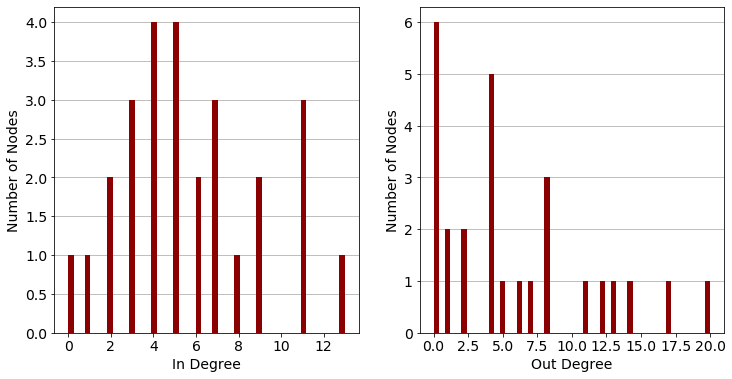

In [20]:
getDegreeDistribution(followG)

Our follower network out-degree has the right-skewed distribution which is what we expect from a social media network. As many people will follow a small amount of people, while only the select few would follow a lot of accounts. However from our in-degree it has nearly a normal distribution, which suggest that our technology twitter list is close connected as they are more likely to be followed by list members.

#### 2.2.5 Centrality

In [21]:
follow_cent_DF = getCentrality(followG)
print("Mean: \n", follow_cent_DF.mean())
print("Min: \n",follow_cent_DF.min())
print("Max: \n",follow_cent_DF.max())

Sorted by eigenvector centrality


eigenvector_centrality  betweenness_centrality  \
techmeme                     0.371                   0.000   
techcrunch                   0.350                   0.004   
mashable                     0.341                   0.248   
engadget                     0.302                   0.061   
wired                        0.299                   0.000   

            closeness_centrality  
techmeme                   0.547  
techcrunch                 0.513  
mashable                   0.549  
engadget                   0.466  
wired                      0.547

eigenvector_centrality  betweenness_centrality  \
fttechnews                  1.459e-02                   0.000   
telegraphtech               1.217e-02                   0.001   
techradar                   5.137e-18                   0.000   

               closeness_centrality  
fttechnews                    0.249  
telegraphtech                 0.230  
techradar                     0.000

Sorted by betweenness centrality


eigenvector_centrality  betweenness_centrality  \
mashable                      0.341                   0.248   
reuterstech                   0.061                   0.104   
arstechnica                   0.113                   0.079   
cnetnews                      0.211                   0.074   
cnet                          0.250                   0.067   

             closeness_centrality  
mashable                    0.549  
reuterstech                 0.308  
arstechnica                 0.405  
cnetnews                    0.427  
cnet                        0.427

eigenvector_centrality  betweenness_centrality  \
techradar                  5.137e-18                     0.0   
fttechnews                 1.459e-02                     0.0   
techrepublic               1.160e-01                     0.0   

              closeness_centrality  
techradar                    0.000  
fttechnews                   0.249  
techrepublic                 0.327

Sorted by closeness centrality


eigenvector_centrality  betweenness_centrality  \
mashable                     0.341                   0.248   
techmeme                     0.371                   0.000   
wired                        0.299                   0.000   
techcrunch                   0.350                   0.004   
gizmodo                      0.247                   0.015   

            closeness_centrality  
mashable                   0.549  
techmeme                   0.547  
wired                      0.547  
techcrunch                 0.513  
gizmodo                    0.466

eigenvector_centrality  betweenness_centrality  \
fttechnews                  1.459e-02                   0.000   
telegraphtech               1.217e-02                   0.001   
techradar                   5.137e-18                   0.000   

               closeness_centrality  
fttechnews                    0.249  
telegraphtech                 0.230  
techradar                     0.000

Mean: 
 eigenvector_centrality    0.157
betweenness_centrality    0.033
closeness_centrality      0.375
dtype: float64
Min: 
 eigenvector_centrality    5.137e-18
betweenness_centrality    0.000e+00
closeness_centrality      0.000e+00
dtype: float64
Max: 
 eigenvector_centrality    0.371
betweenness_centrality    0.248
closeness_centrality      0.549
dtype: float64


From looking at the betweenness and closeness we that again mashable is an influential node in our network as they have the highest betweenness and closeness. Which means they are able to access information easily due to the close connection to other nodes in the network, and they are a possible broker, as they are in the shortest path for many nodes.

However they are only 3rd in the eigenvector rankings, which suggest that techmeme and techcrunch are connected to mashable, and/or they are connected to other influential nodes in our network. Both techmeme and techcrunch have a high betweenness score with a low closeness score, which suggest that they are close to many influential nodes, but they are not in anyone’s shortest path to the network. Which could further suggest that if we were to remove them from the network we wouldn’t see a disruption to the pathing of the network, however we could see an effect in the closeness of the follow network.

## 3.0 Reply network
Replies are when a user would comment on another uses post. Our tweet list consists of tweets posted from members from our list, which means that only list members will be the source of our edges, however we can have nodes which are not part of our original list, as it represents replies done by our members on other accounts tweets.

### 3.1 Construction
I will create a directed weighted network, as the reply relation is bi-directional and you can reply to a user multiple times, (and on the same post)

I will search through our tweet json list to gather the replyUser who is our list member who posted the reply, and to gather the inReplyUser who represents who we are replying to. To represent this users I will use their screen names as they are unique, and are more understandable/recognisable than id.

C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


<Figure size 1440x720 with 0 Axes>

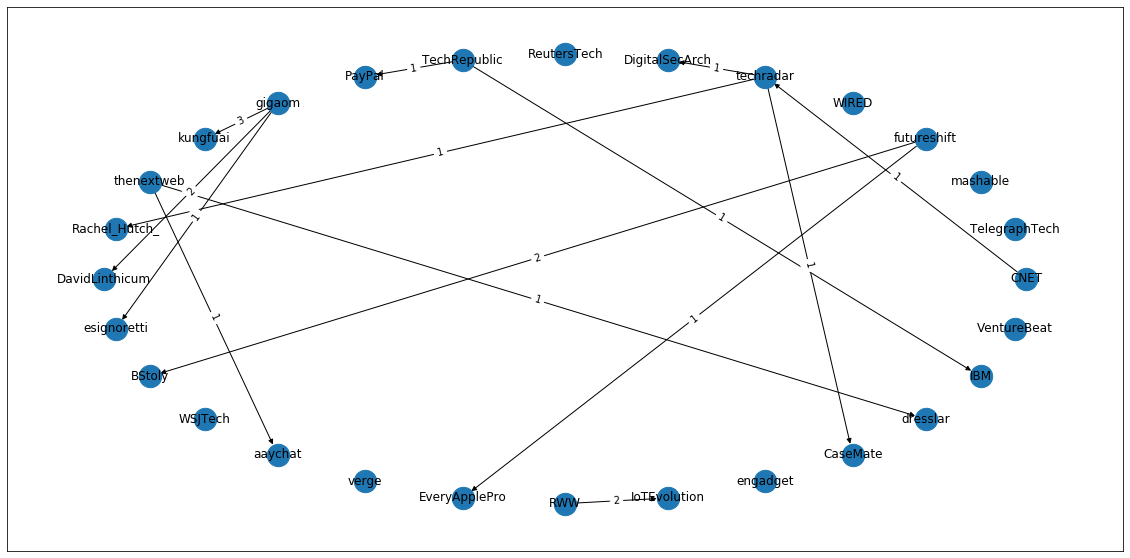

Nodes: 28, Edges: 26


In [22]:
replyG = nx.DiGraph()

for tweet in tweet_list:
    data = json.loads( tweet )
    #gather user data
    replyUser = data["user"]["screen_name"]
    inReplyUser = data["in_reply_to_screen_name"]
    if inReplyUser is not None:
        #create edges and nodes with weights for each mention
        if replyG.has_edge(replyUser, inReplyUser):
            replyG[replyUser][inReplyUser]["weight"] += 1
        else:
            replyG.add_edge(replyUser, inReplyUser, weight = 1)

#Print Network with names and weights
displayNetwork(replyG)

### 3.2 Characterisation

#### 3.2.1 Structure

In [23]:
getStructure(replyG)

Network's Density: 0.03
Network is not strongly connected, there are 28 components.
Network is not weakly connected, there are 14 components.


From this we can see that the reply network is a very unconnected. It’s has a very low density, not strongly connected, and not even weakly connected, which means that if we replaced all of its directed edges with undirected edges it would not produce a connected (undirected) graph.

This could be due to however all of the isolated nodes in our network. These could represent users which reply to their own tweets. To represent users who reply to their tweets I will use nodes_with_selfloops function.

In [24]:
#Identify self loop nodes
selfLoopNodes = list(replyG.nodes_with_selfloops())
print(selfLoopNodes)

['CNET', 'TelegraphTech', 'mashable', 'futureshift', 'WIRED', 'techradar', 'ReutersTech', 'thenextweb', 'WSJTech', 'verge', 'engadget', 'VentureBeat']


Here we can see who self replies. This list includes users who only self reply, and who also have replied to others. I want to remove the users who only self reply/loop, and they do not show the connection of the network.

While I remove nodes I will also print out the amount of times they reply to themselves.

In [25]:
toKeep = []
for node in selfLoopNodes:
    print("%s replied to itself %d time(s)" %(node, replyG[node][node]['weight']))
    #Remove Users who reply to other user's posts
    if len(replyG.edges(node)) > 1:
        toKeep.append(node)
#Remove only self-loop Nodes
for node in toKeep:
        selfLoopNodes.remove(node)
        
print("Nodes which only Self-Replied:", selfLoopNodes)

totalReplies = replyG.size(weight='weight')
print("Total replies are %d, which means that TelegraphTech's self replies account for %.2f of the replies" %(totalReplies, (34/totalReplies)))

CNET replied to itself 24 time(s)
TelegraphTech replied to itself 34 time(s)
mashable replied to itself 8 time(s)
futureshift replied to itself 32 time(s)
WIRED replied to itself 24 time(s)
techradar replied to itself 5 time(s)
ReutersTech replied to itself 1 time(s)
thenextweb replied to itself 1 time(s)
WSJTech replied to itself 3 time(s)
verge replied to itself 2 time(s)
engadget replied to itself 1 time(s)
VentureBeat replied to itself 1 time(s)
Nodes which only Self-Replied: ['TelegraphTech', 'mashable', 'WIRED', 'ReutersTech', 'WSJTech', 'verge', 'engadget', 'VentureBeat']
Total replies are 155, which means that TelegraphTech's self replies account for 0.22 of the replies


From this we can see that TelegraphTech self looped the most with 34 different replies to their own posts. Which accounted for 22% of the replies for the whole network, this shows the importance TelegraphTech places in replies, and possibly they believe its good for advertisement, or they possibly have good viewer communication, as they might reply to other users replied to their posts.

Let’s now remove these only self-replying nodes, and look at the interconnected relationships in our reply network.

Nodes Removed


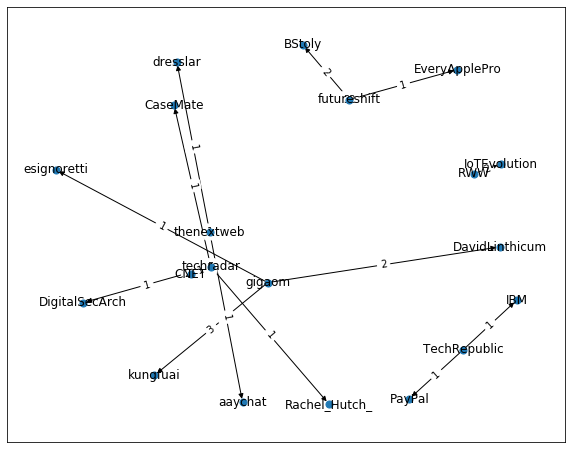

In [26]:
removeSelfLoopG = replyG.copy()
#Remove Users who only self loop
removeSelfLoopG.remove_nodes_from(selfLoopNodes)
print("Nodes Removed")
#Draw new network
pos = nx.drawing.spring_layout(removeSelfLoopG)
labels = nx.get_edge_attributes(removeSelfLoopG,'weight')
plt.figure(figsize=(10,8))
nx.draw_networkx(removeSelfLoopG, pos=pos, with_labels=True, node_size = 50, font_size = 12)
nx.draw_networkx_edge_labels(removeSelfLoopG,pos=pos,edge_labels=labels)
plt.show()

In [27]:
getStructure(removeSelfLoopG)

Network's Density: 0.05
Network is not strongly connected, there are 20 components.
Network is not weakly connected, there are 6 components.


Even when we removed the only self-replying nodes we still have a very disconnected network, which expressed that only a small group of users reply to each other’s posts. Possibly if we included non-members tweets in our network we could see if the relationship between the repliers is stronger, or more connected.

We can see the different subgroups in the above visual. However let’s look at the top subgroup.

<Figure size 720x360 with 0 Axes>

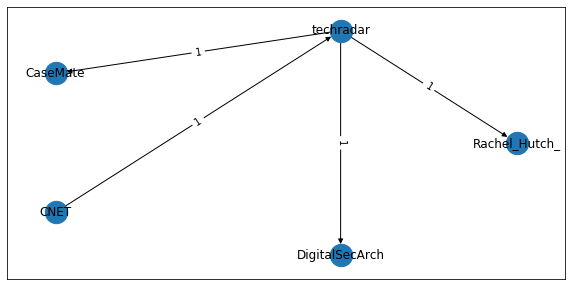

Nodes: 5, Edges: 6


<Figure size 720x360 with 0 Axes>

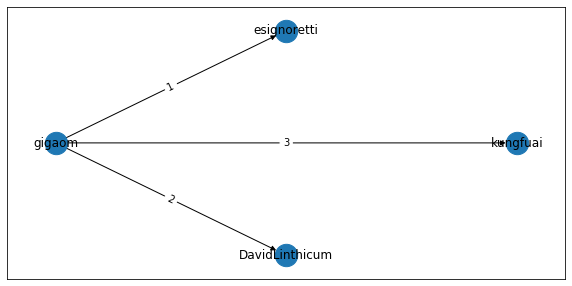

Nodes: 4, Edges: 3


<Figure size 720x360 with 0 Axes>

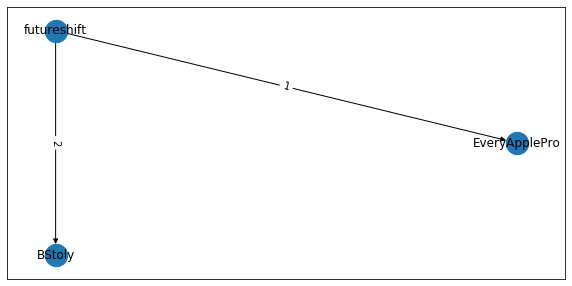

Nodes: 3, Edges: 3


<Figure size 720x360 with 0 Axes>

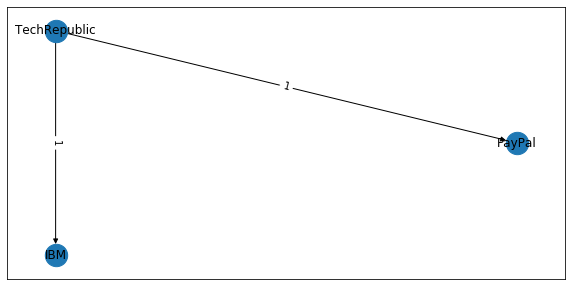

Nodes: 3, Edges: 2


In [28]:
limit = 0
for graph in sorted(nx.weakly_connected_component_subgraphs(removeSelfLoopG), key=len, reverse=True):
    if limit > 3:
        break
    displayNetwork(graph, sizeX= 10, sizeY=5)    
    limit += 1

From these subgraphs we can see the relationship between small clusters on users in our list, sadly we do not see any reciprocal relationships, however we can see that gigamon has replied 3 times to kungfuai posts, and twice to DavidLinthicum. Which shows that while gigamon reply cluster is smaller, they are more consistent, as they repeat replies. While Techradar has a same amount of users they reply too, they only reply once, which suggest a weaker relationship.

#### 3.2.2 Clustering

In [29]:
getClustering(replyG)

clustering
CNET                    0
TelegraphTech           0
IBM                     0
dresslar                0
CaseMate                0

clustering
futureshift           0
mashable              0
VentureBeat           0

From this we can see that we don't have any clustering in our network. Which means that no user in our network is connected to their neighbour’s neighbours, thus meaning that there aren’t repliers who reply to fellow replies. This shows a real lacking in the connection in our reply network, and possibly shows that the technology twitter community doesn't use replies as a form of communication between the users in the tech twitter list.

#### 3.2.3 Reciprocity

In [30]:
getReciprocity(replyG)

Reciprocity 0.00


Again we see that we don't have users which reply to each other, which again shows the lack of relationships in our reply network, thus reinforces the idea that the members in our tech list don't put faith into the reply system as a form of communication, and they only self reply. However due to the fact we do not get the tweets of users outside of our members list, possibly if we extended the network to any users they reply to we could see a more reciprocal network.

For curiosity sake, lets see how many edges there are which connected our members from the list. This could show that many of our replies are not actually within the members, which would explain the lack of reciprocity and clustering.

In [31]:
count = 0
selfLoopCount = 0
membersEdges = []
for n1 in replyG.nodes():
    if n1 in membersNames:
        for n2 in replyG.nodes():
             if n2 in membersNames:
                    #Self loop nodes
                    if not n1 == n2:
                        if replyG.has_edge(n1,n2):
                            membersEdges.append([n1,n2])
                            count+=1
                    else:
                        selfLoopCount+=1
print("Number of replied between members is %d" %count)
print(membersEdges, "weight:", replyG['CNET']['techradar']['weight'])
print("Number of self-replies is %d" %selfLoopCount)

Number of replied between members is 1
[['CNET', 'techradar']] weight: 1
Number of self-replies is 15


CNET only replied once to a fellow list member, which as techradar. Thus proving that the tech twitter lists do not reply to each other. However 15 of them self reply, which shows that they place a high importance in self replies.

#### 3.2.4 Degree Centrality and Degree Distribution

In [32]:
reply_degree_cent_DF = getDegreeCent(replyG)

Sorted by weighted in degree centrality


in_degree_centrality_weighted  out_degree_centrality_weighted
TelegraphTech                          0.219                           0.219
futureshift                            0.206                           0.226
CNET                                   0.155                           0.161
WIRED                                  0.155                           0.155
mashable                               0.052                           0.052

in_degree_centrality_weighted  out_degree_centrality_weighted
gigaom                                  0.0                           0.039
TechRepublic                            0.0                           0.013
RWW                                     0.0                           0.013

Sorted by weighted out degree centrality


in_degree_centrality_weighted  out_degree_centrality_weighted
futureshift                            0.206                           0.226
TelegraphTech                          0.219                           0.219
CNET                                   0.155                           0.161
WIRED                                  0.155                           0.155
mashable                               0.052                           0.052

in_degree_centrality_weighted  out_degree_centrality_weighted
dresslar                                0.006                             0.0
IBM                                     0.006                             0.0
DavidLinthicum                          0.013                             0.0

TelegraphTech has highest in-degree, which was the same as their out-degree, however as we shown earlier these are all self-replies, which shows how the majority of the replies are self replies in this network, and how TelegraphTech accounts for the majority of them.

However futureshift had the highest outdegree, which shows that they replied the most in our network.

Let's remove the self replying nodes and see if we have a difference in our degrees. 

In [33]:
noselfreply_degree_cent_DF = getDegreeCent(removeSelfLoopG)

Sorted by weighted in degree centrality


in_degree_centrality_weighted  out_degree_centrality_weighted
futureshift                           0.395                           0.432
CNET                                  0.296                           0.309
techradar                             0.074                           0.099
kungfuai                              0.037                           0.000
IoTEvolution                          0.025                           0.000

in_degree_centrality_weighted  out_degree_centrality_weighted
gigaom                                  0.0                           0.074
TechRepublic                            0.0                           0.025
RWW                                     0.0                           0.025

Sorted by weighted out degree centrality


in_degree_centrality_weighted  out_degree_centrality_weighted
futureshift                          0.395                           0.432
CNET                                 0.296                           0.309
techradar                            0.074                           0.099
gigaom                               0.000                           0.074
thenextweb                           0.012                           0.037

in_degree_centrality_weighted  out_degree_centrality_weighted
PayPal                                  0.012                             0.0
DigitalSecArch                          0.012                             0.0
IBM                                     0.012                             0.0

When we remove the self-replies we see that futureshift is ontop with both in-degree and out-degree centrality, which shows that they have a wider connection with users in our reply network, as they do more than just self reply.

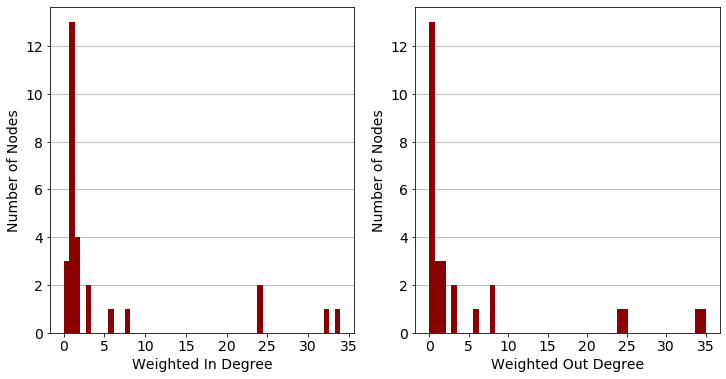

In [34]:
getDegreeDistribution(replyG)

These distributions of right-skewed express the expected distribution which you find in social networks, it also shows how much of an effect the users who self-replied had on our network, as they greatly lengthen the range of both in-degree and out-degree counts.

#### 3.2.5 Centrality

In [35]:
#getCentrality(replyG)
reply_between = pd.Series(dict(nx.betweenness_centrality(replyG)), name="betweenness_centrality")
reply_closeness = pd.Series(dict(nx.closeness_centrality(replyG)), name="closeness_centrality")


centralityDF = pd.concat([reply_between, reply_closeness], axis=1)
    
#Display df sorted by each centrality

print("Sorted by betweenness centrality")
displayDF(centralityDF, "betweenness_centrality")
print("Sorted by closeness centrality")
displayDF(centralityDF, "closeness_centrality")

Sorted by betweenness centrality


betweenness_centrality  closeness_centrality
techradar                     0.004                 0.037
CNET                          0.000                 0.000
esignoretti                   0.000                 0.037
IBM                           0.000                 0.037
dresslar                      0.000                 0.037

betweenness_centrality  closeness_centrality
futureshift                     0.0                   0.0
mashable                        0.0                   0.0
VentureBeat                     0.0                   0.0

Sorted by closeness centrality


betweenness_centrality  closeness_centrality
Rachel_Hutch_                      0.0                 0.049
CaseMate                           0.0                 0.049
DigitalSecArch                     0.0                 0.049
DavidLinthicum                     0.0                 0.037
PayPal                             0.0                 0.037

betweenness_centrality  closeness_centrality
futureshift                     0.0                   0.0
mashable                        0.0                   0.0
VentureBeat                     0.0                   0.0

Because our reply network is very unconnected, and thus has a very low betweenness and closeness, we were unable to calculate the eigenvectors values for our reply network. However from these we can see that techradar controls the flow of information in our network, as it has the highest betweenness score and thus they could be a broker for our reply network. While Rachel_Hutch_, CaseMate and DigitalSecArch have the highest closeness centrality, which suggest that more of our members reply to all these twitter accounts, which would make them closer together.

If you look back on our subgraph networks we can see that techradar is the user which connects these top closeness accounts (Rachel_Hutch_, CaseMate and DigitalSecArch), thus showing that techradar is an influencer in this network.

## 4.0 Mention Network
Mention networks represent the relationship between users who mention (@) each other in their tweets. For this interaction a single user can mention many different accounts in one tweet. Again our tweets will only be from our members of our twitter list, however we will have nodes which out outside of our list as they can mention any twitter account.

### 4.1 Construction
The mention relation is directional and weighted as you can mention someone multiple times, with different tweets. Thus we will create a directed weighted graph to represent our mention network.

The construction is similar to our reply network, however this time we can have many mentions within each tweet, which is held in a list. Therefore for each tweet we will need to cycle through the mention list, and create an edge for each user mentioned in the tweet.

C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


<Figure size 1440x720 with 0 Axes>

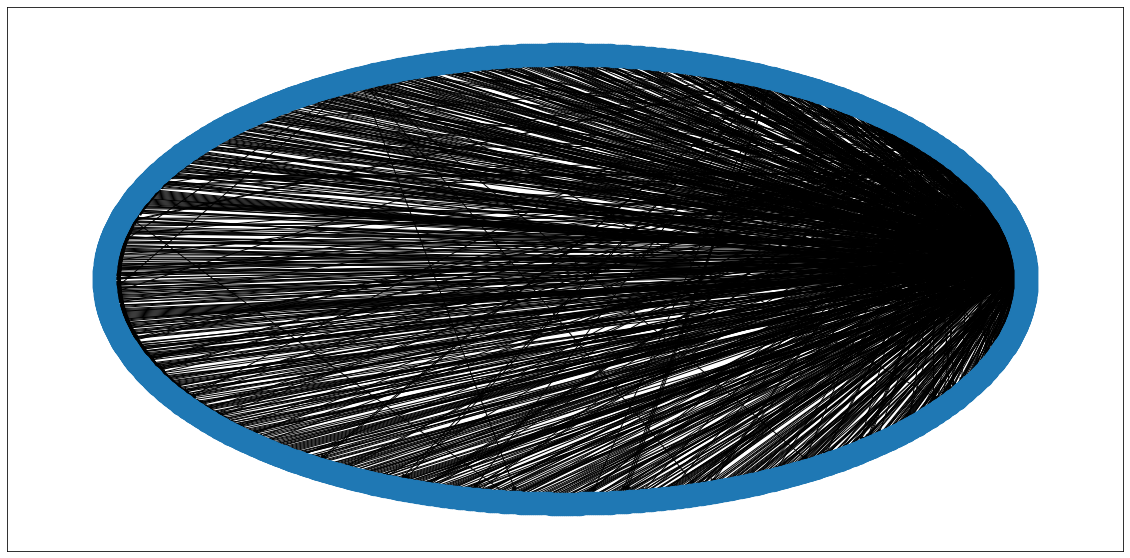

Nodes: 1400, Edges: 1554


In [36]:
mentionG = nx.DiGraph()

for tweet in tweet_list:
    data = json.loads( tweet )
    #Gather node data
    user = data["user"]["screen_name"]
    mentionedUsers = data["entities"]["user_mentions"]
    for mention in mentionedUsers:
        mentionUser = mention["screen_name"]
        #Create nodes and edges with weights
        if mentionG.has_edge(user, mentionUser):
            mentionG[user][mentionUser]["weight"] += 1
        else:
            mentionG.add_edge(user, mentionUser, weight = 1)

displayNetwork(mentionG)

### 4.2 Characterisation

#### 4.2.1 Structure

In [37]:
getStructure(mentionG)

Network's Density: 0.00
Network is not strongly connected, there are 1397 components.
Network is not weakly connected, there are 3 components.


Even though our network is very large we have a very disconnected graph, as we have many nodes, with only a little amount of edges. This could suggest that the users from our list mention very different accounts, an thus there is very little connection between then, and many different nodes were added. This is also due to the construction of the network, as we do not create an edge between the users mentioned in the same tweet, we only make an edge between the tweet author and the mentioned user.

If we compare the number of strongly connected components (1397), and the number of nodes (1400). We can suggest that we have 3 groups of nodes which form a strongly connected subcomponent while the others components are only a subgraph with 1 node.

<Figure size 720x360 with 0 Axes>

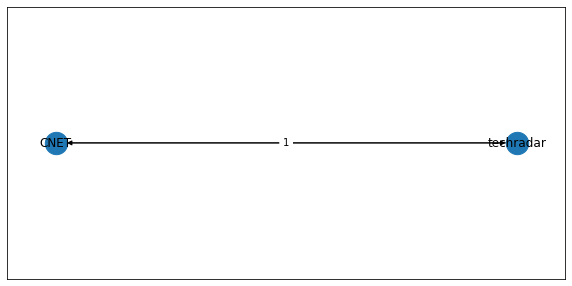

Nodes: 2, Edges: 4


<Figure size 720x360 with 0 Axes>

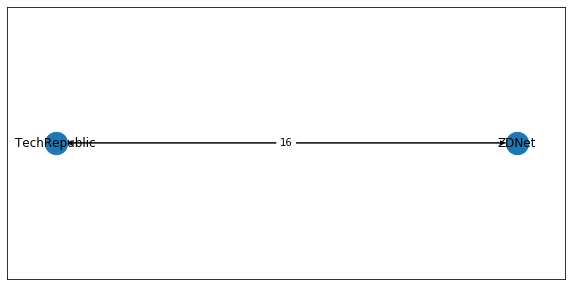

Nodes: 2, Edges: 3


<Figure size 720x360 with 0 Axes>

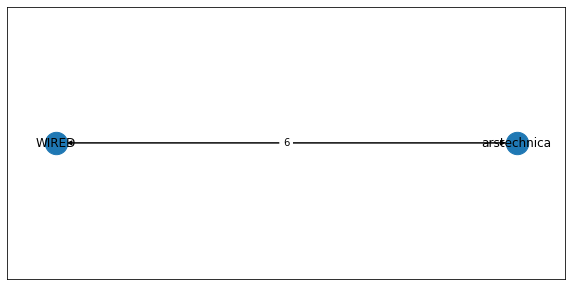

Nodes: 2, Edges: 4


<Figure size 720x360 with 0 Axes>

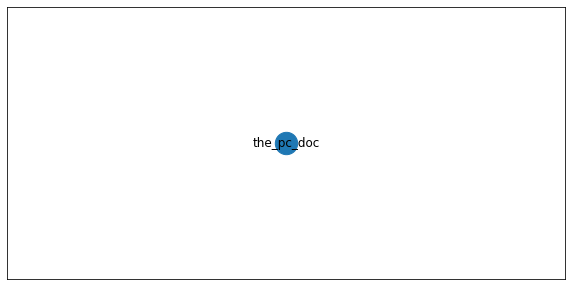

Nodes: 1, Edges: 0


In [38]:
limit = 1
for graph in sorted(nx.strongly_connected_component_subgraphs(mentionG), key=len, reverse=True):
    if limit > 4:
        break
    displayNetwork(graph, sizeX= 10, sizeY=5)    
    limit += 1

From these drawn graphs we can see that our strongly connected subcomponents show 3 reciprocal networks, and the strong relation between them. I will explore them fully in our Reciprocity section.

Let’s look at our weakly connected sub graphs.

<Figure size 720x360 with 0 Axes>

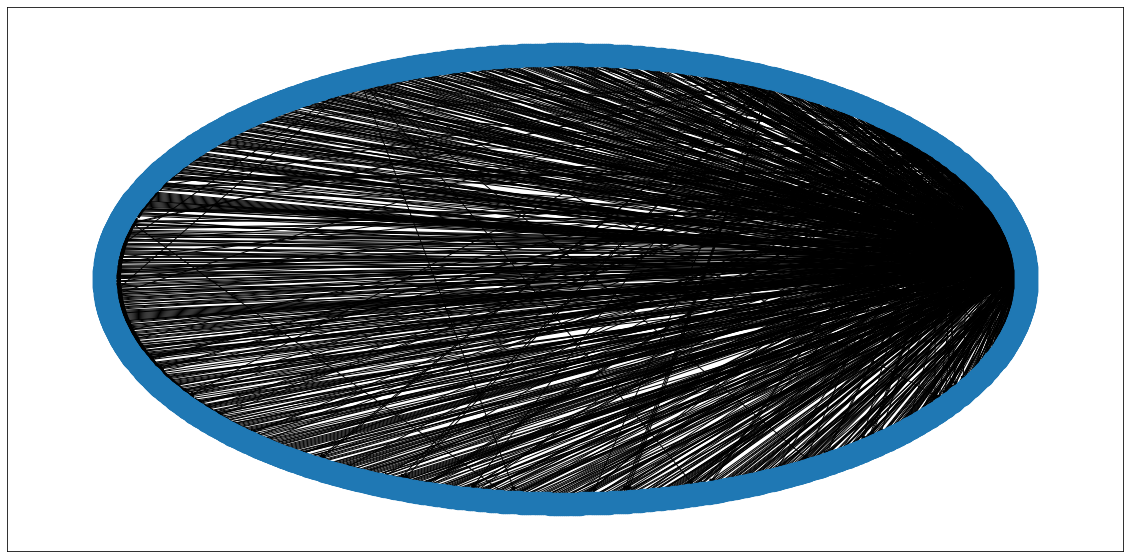

Nodes: 1372, Edges: 1528


<Figure size 720x360 with 0 Axes>

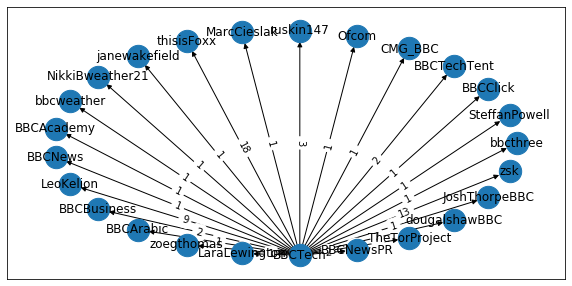

Nodes: 25, Edges: 24


<Figure size 720x360 with 0 Axes>

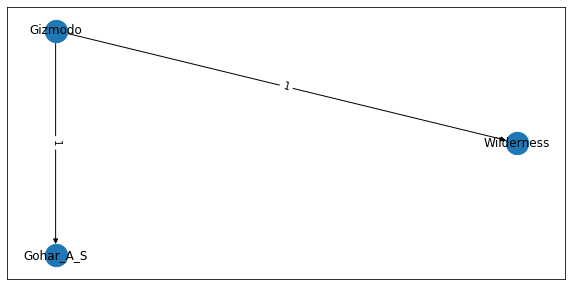

Nodes: 3, Edges: 2


In [39]:
for graph in sorted(nx.weakly_connected_component_subgraphs(mentionG), key=len, reverse=True):
    displayNetwork(graph, sizeX= 10, sizeY=5)    

Our first and largest subgraph represents the majority of our network. It we look at our next 2 subgraphs. We can see that BBCTech has its own large group of user's its mentions, and as you would expect they are mainly other BBC twitter accounts. BBC mentions another news channel thisisFoxx, and zsk the most. User zsk is Zoe Kleinman, who is a tech reporter BBC, which shows that they tweet a lot of news stories which Zoe Kleinman reports, and thus shows the employer and employee relationship between BBC Tech and their reporters.

#### 4.2.2 Clustering

In [40]:
getClustering(mentionG)

clustering
edbott                 1.0
KarenRoby6             1.0
billdetwiler           1.0
TonyaHallRadio         1.0
BStoly                 0.5

clustering
jemaswad             0.0
VDC_Research         0.0
IXIAcom              0.0

From this we can see that edbott, KarenRoby6, billdetwilr, and TonyaHallRadio have a complete cluster. Which means that the users which mention these accounts also mentioned each other. Which will show the strong relationship between users in our lists and which topics/users they similar talk about.

In [41]:
print("edbott's edges", list(mentionG.in_edges("edbott")))
print("Is there a edge between ZDNet and TechRepublic?", mentionG.has_edge("ZDNet", "TechRepublic"), mentionG.has_edge("TechRepublic", "ZDNet"))

edbott's edges [('ZDNet', 'edbott'), ('TechRepublic', 'edbott')]
Is there a edge between ZDNet and TechRepublic? True True


Here we can see that ZDNet and TechRepublic have mentioned each other, they have also both mentioned edbott, who is Ed Bott as tech journalist. Which means that either ZDNet and TechRepublic have reports which were authored by Ed Bott, or they both posted tweets about Ed Bott.

#### 4.2.3 Reciprocity

In [42]:
getReciprocity(mentionG)

Reciprocity 0.00
ZDNet <--> TechRepublic
CNET <--> techradar
arstechnica <--> WIRED


Due to the great size of the network and how in general we have a very low connectivity we have a very low Reciprocity score, as there are not enough similarities in the users mentioned.

As we saw before in our strongly connected subgraphs we have 3 reciprocal pairs of users. This shows the 2 way relationship between these 2 accounts, and that they have a strong relationship, by looking at the weights of these reciprocal edges we will be able to see the strength of the relationship.

Before: Nodes: 1400 Edges: 1554
After: Nodes: 6 Edges: 8


C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<Figure size 1440x720 with 0 Axes>

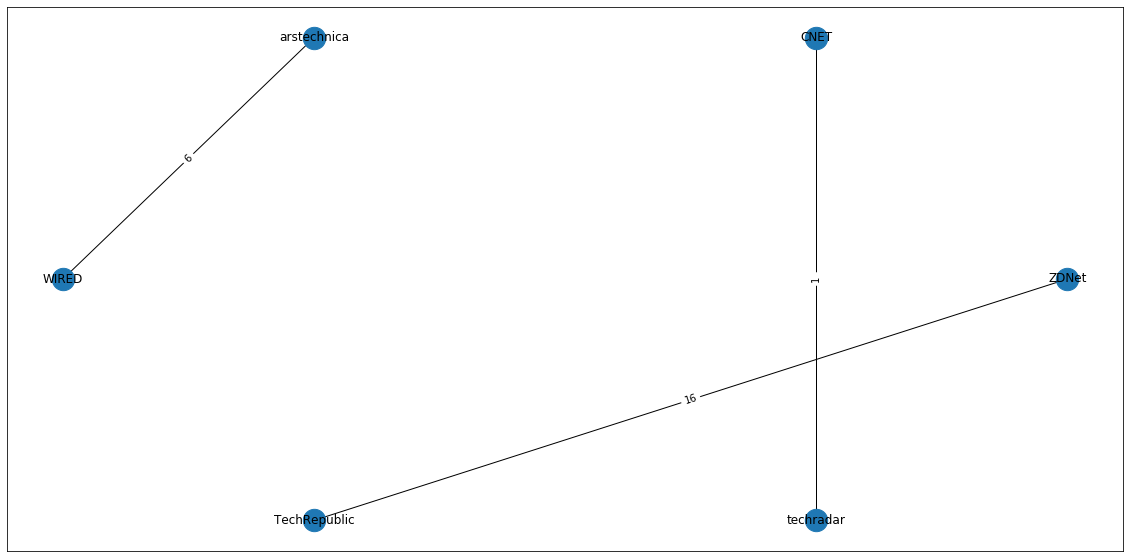

Nodes: 6, Edges: 8


In [43]:
mention_reciprocal = getReciprocalNetwork(mentionG)

This shows that TechRepublic and ZDNet have the strongest relationship has they have mentioned each other 16 times total. We also saw that they mention similar accounts in our clustering section, thus emphasising that these 2 accounts have a strong connected relationship as they frequently posts about each other and about the same topics.

#### 4.2.4 Degree Centrality and Degree Distribution

In [44]:
mention_degree_DF = getDegreeCent(mentionG)

Sorted by weighted in degree centrality


in_degree_centrality_weighted  out_degree_centrality_weighted
esignoretti                             0.017                             0.0
napilopez                               0.014                             0.0
byronreese                              0.013                             0.0
IndianIdle                              0.012                             0.0
Kyle_L_Wiggers                          0.012                             0.0

in_degree_centrality_weighted  out_degree_centrality_weighted
RWW                                0.0                       5.111e-02
BBCTech                            0.0                       1.373e-02
Gizmodo                            0.0                       3.814e-04

Sorted by weighted out degree centrality


in_degree_centrality_weighted  out_degree_centrality_weighted
gigaom                             1.068e-02                           0.277
TechCrunch                         1.907e-04                           0.080
Techmeme                           0.000e+00                           0.076
ForbesTech                         5.721e-04                           0.074
TelegraphTech                      1.335e-03                           0.073

in_degree_centrality_weighted  out_degree_centrality_weighted
todoist                         3.814e-04                             0.0
briankrebs                      1.907e-04                             0.0
IXIAcom                         1.907e-04                             0.0

From the in-degree we can see that esignoretti is the most mentioned account, its owned by Enrico Signoretti who is an Independent IT analyst. Which suggest that Mr. Signoretti publishes stories for multiple different tech news accounts and thus mentioned a lot by users in our members list, or our members have mentioned stories written by Mr. Signoretti. You could suggest that Mr. Signoretti has a very high influence on the technological news, and has a large effect on our list members, due to the high amount of mentions he has.

gigaom has an out-degree centrality of 0.277 which means that they account for a high amount of the mentions in our network, and thus expressing that gigom mentions the most in our network. If were to look at the non-weighted out-degree we can see which users mention the most variety of other users.

In [45]:
mention_nonW = pd.DataFrame(pd.Series(dict(nx.out_degree_centrality(mentionG)), name="out_degree_centrality"))
displayDF(mention_nonW, "out_degree_centrality")

out_degree_centrality
gigaom                         0.194
Techmeme                       0.182
RWW                            0.124
TelegraphTech                  0.091
ForbesTech                     0.069

out_degree_centrality
todoist                       0.0
briankrebs                    0.0
IXIAcom                       0.0

The non-weighted degree shows that gigaom also has the highest variance of mentions along with the most mentions. This shows that gigamon connects a lot of users together, has they mention a lot of different users. It also can show that gigamon places a high importance of mentions in their tweets.

gigaom was also top 4 in our out-weighted degree centrality in our reply network, from this you could suggest that gigaom is the most active account in our twitter list, due to the high amount of mentions and replies they post.

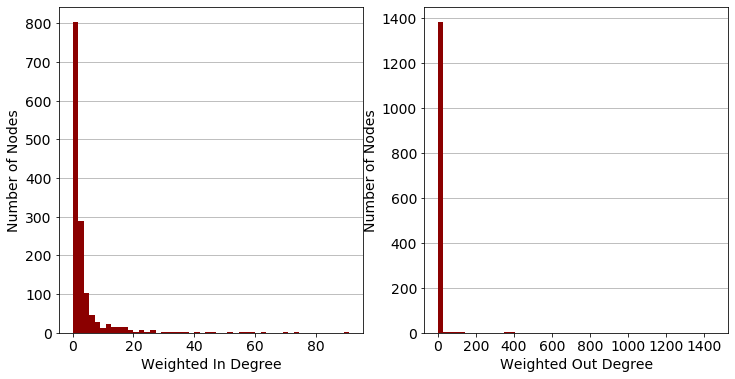

In [46]:
getDegreeDistribution(mentionG)

Again we have 2 right skewed distributions which is what we expect from a social network. However we can see that due to the fact that only our members list users can have a out-degree, we have majority of nodes which have an outdegree of 0, which then disrupts our distribution.

Let’s then calculate the distribution for only our twitter list members out-degree.

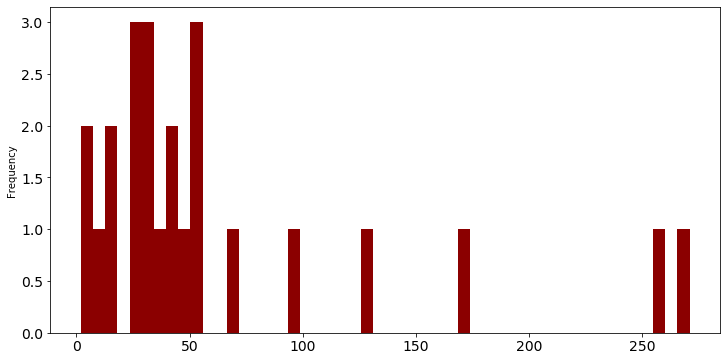

In [47]:
mention_degree = pd.DataFrame(pd.Series(dict(mentionG.out_degree(membersNames)), name="out_degree"))
mention_degree.plot.hist(figsize=(12,6), fontsize=14, legend=None, color="darkred", bins=50, zorder=3)  

Here we can see a better representation of our out-degree distribution as we have removed the nodes which can only have an out-degree of 0. From this new distribution we can see that it is still rightly skewed, and a majority of our members mention users 25-50 times.

#### 4.2.5 Centrality

In [48]:
mention_cent_df = getCentrality(mentionG)

Sorted by eigenvector centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
Samsung                     0.199                        3.456e-08   
CNET                        0.199                        7.492e-08   
techradar                   0.199                        4.889e-08   
Google                      0.099                        1.028e-02   
jdolcourt                   0.099                        5.150e-08   

           betweenness_centrality  closeness_centrality  
Samsung                 0.000e+00                 0.003  
CNET                    1.017e-04                 0.002  
techradar               6.136e-05                 0.001  
Google                  0.000e+00                 0.005  
jdolcourt               0.000e+00                 0.003

eigenvector_centrality  eigenvector_centrality_weighted  \
Gizmodo               3.324e-25                        4.531e-17   
BBCTech               3.324e-25                        4.531e-17   
RWW                   3.324e-25                        4.531e-17   

         betweenness_centrality  closeness_centrality  
Gizmodo                     0.0                   0.0  
BBCTech                     0.0                   0.0  
RWW                         0.0                   0.0

Sorted by weighted eigenvector centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
esignoretti                  1.871e-10                            0.468   
byronreese                   1.871e-10                            0.360   
DavidLinthicum               1.871e-10                            0.303   
jonno                        1.871e-10                            0.298   
gigaom                       1.871e-10                            0.288   

                betweenness_centrality  closeness_centrality  
esignoretti                        0.0             7.148e-04  
byronreese                         0.0             7.148e-04  
DavidLinthicum                     0.0             7.148e-04  
jonno                              0.0             7.148e-04  
gigaom                             0.0             0.000e+00

eigenvector_centrality  eigenvector_centrality_weighted  \
technology               3.324e-25                        4.531e-17   
RWW                      3.324e-25                        4.531e-17   
BBCTech                  3.324e-25                        4.531e-17   

            betweenness_centrality  closeness_centrality  
technology                     0.0                   0.0  
RWW                            0.0                   0.0  
BBCTech                        0.0                   0.0

Sorted by betweenness centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
CNET                       1.988e-01                        7.492e-08   
techradar                  1.987e-01                        4.889e-08   
TechRepublic               1.178e-04                        1.126e-07   
TechCrunch                 1.871e-10                        5.139e-03   
arstechnica                7.955e-02                        1.707e-06   

              betweenness_centrality  closeness_centrality  
CNET                       1.017e-04             1.608e-03  
techradar                  6.136e-05             1.072e-03  
TechRepublic               5.266e-05             7.148e-04  
TechCrunch                 2.659e-05             7.148e-04  
arstechnica                2.250e-05             7.148e-04

eigenvector_centrality  eigenvector_centrality_weighted  \
OutOnALumb                 9.932e-02                        1.038e-08   
TheAlexKnapp               1.871e-10                        1.584e-11   
IXIAcom                    1.871e-10                        5.139e-03   

              betweenness_centrality  closeness_centrality  
OutOnALumb                       0.0             1.144e-03  
TheAlexKnapp                     0.0             7.148e-04  
IXIAcom                          0.0             7.148e-04

Sorted by closeness centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
Google                   9.944e-02                        1.028e-02   
campuscodi               1.178e-04                        2.341e-07   
Samsung                  1.988e-01                        3.456e-08   
LiamT                    1.178e-04                        2.341e-07   
jdolcourt                9.944e-02                        5.150e-08   

            betweenness_centrality  closeness_centrality  
Google                         0.0                 0.005  
campuscodi                     0.0                 0.004  
Samsung                        0.0                 0.003  
LiamT                          0.0                 0.003  
jdolcourt                      0.0                 0.003

eigenvector_centrality  eigenvector_centrality_weighted  \
Techmeme               3.324e-25                        4.531e-17   
RWW                    3.324e-25                        4.531e-17   
BBCTech                3.324e-25                        4.531e-17   

          betweenness_centrality  closeness_centrality  
Techmeme                     0.0                   0.0  
RWW                          0.0                   0.0  
BBCTech                      0.0                   0.0

Due to the small connectivity in our network we have very low betweenness and closeness centrality scores. However our eigenvector centralities provide some interesting insight. If we want to see the nodes which influence more of a variety of nodes we can look at the un-weighed eigenvector. Samgsung, CNET, and Techradar have the highest unweighted eigenvectors and thus influence the widest range of nodes. While esignoretti has the highest weighted eigenvector centrality score, which reinforces the idea that Mr. Signoretti has a major influence on the network especially the tech news accounts.

## 5.0 User-hashtag Network
A User-Hashtag network represents the relationship between users and what hashtags they post. These can be used to represent which account comment on which themes or topics.

### 5.1 Construction
We have 2 different categories of nodes, User Nodes and Hashtag Nodes, thus we have a bipartite network. For this network the edges can only be in between the opposite category of nodes, and the nodes within the category cannot connected to each other. We want our network to be able to distinguish between, which we can use using a bipartite label of 0 for users, and 1 for hashtags.

We use a set to hold each of our categories, as sets don't allow repeated elements, we will use these to keep track of which nodes are part of which group.

I will be using collection’s Counters to keep track of the weights for each pair of nodes, which we can later uses to create the edges.

Some of the user’s names were used also used as hashtags which meant that after construction our network wasn't a bipartite network. To solve this I placed a '#' in front of every hashtag recorded, this means we were able to easily distinguish between the 2 node groups, and removes any chance of their being name conflict.

Bipartite? True
Connected? False
23 Tweeter, 715 Hashtags


C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<Figure size 1440x720 with 0 Axes>

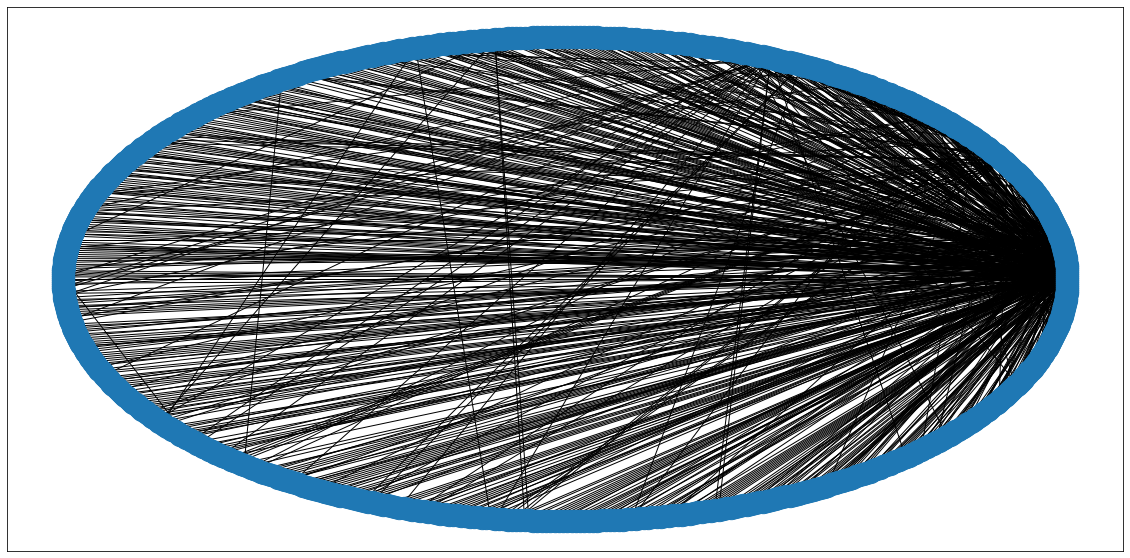

Nodes: 738, Edges: 870


In [49]:
from collections import Counter

userHashtagG = nx.Graph()
#Sets to hold 2 Node classes, Users, and Hashtags
userNodes, hashtagNodes = set(), set()
#Count pairs for weights
pair_counts = Counter()
#Gather User, hashtag data, and identify edges
for tweet in tweet_list:
    data = json.loads( tweet )
    user = data["user"]["screen_name"]
    hashtags = data["entities"]["hashtags"] 
    for hashtag in hashtags:
        #name = members[user]["screen_name"]
        if not user in userNodes:
            #userHashtagG.add_node(user, screen_name=name, bipartite=0)
            userHashtagG.add_node(user, bipartite=0)
            userNodes.add(user)
        tag = hashtag["text"]
        if not tag in hashtagNodes:
            newtag= "#"+tag
            userHashtagG.add_node(newtag, bipartite=1)
            hashtagNodes.add(newtag)
        pair = frozenset( [user, newtag] )
        pair_counts[pair] += 1

#Create nodes and edges
for pair in pair_counts:
    userHashtagG.add_edge( *pair, weight=pair_counts[pair] )

print("Bipartite?", bipartite.is_bipartite(userHashtagG))
print("Connected?", nx.is_connected(userHashtagG))
#print(nx.number_connected_components(userHashtagG), "components.")
print( "%d Tweeter, %d Hashtags" % ( len(userNodes), len(hashtagNodes) ) )
displayNetwork(userHashtagG)

From the quick checks we can see that we have created a Bipartite Network, however it is not connected, which means we have hashtags which are exclusive to some users. Due to this we cannot use bipartite.sets() to separate my 2 groups of nodes. However I already have collect 2 sets for each category, and will therefore use these instead for distinguishing my nodes. To display my networks I will change the colour and the position for each set, which can create an easier visualisation of the 2 categories. As we get no useful information of a bipartite using the default drawing method demonstrated above.

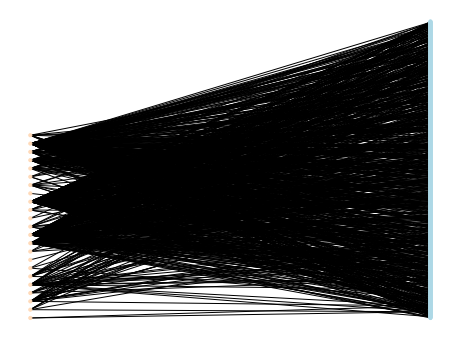

In [50]:
color_map, pos = {}, {}
#For each set, assign them different colours and position
for i, node in enumerate(userNodes):
    pos[node] = (0, i*500)
    color_map[node] = "#ffdab9"
for i, node in enumerate(hashtagNodes):
    pos[node] = (0.5, i*25)
    color_map[node] = "lightblue"
colors = [color_map[node] for node in userHashtagG.nodes()]

#Draw the network    
plt.figure(figsize=(8,6))
nx.draw_networkx(userHashtagG, pos=pos, with_labels=False, 
        node_size = 10,
        font_size = 14,
        node_color = colors)
plt.axis("off")
plt.show()

### 5.2 Characterisation 
We have different centrality and clustering functions for bipartite networks, as they normalise the data differently, and thus for the characterisations these functions will be used instead.  For the degrees I will look at each category separately, which will allow me to see which users use the most hashtags, and which hashtags are most popular. 

#### 5.2.1 Structure

In [51]:
getStructure(userHashtagG, userNodes)

Network's Density: 0.05
Network is not connected, there are 4 components.


Our network is not very connected as it has a very low density. Because our User-hashtag Network is separated and has 4 components, I will draw each of our individual networks, which should give us more of an insight into the hashtag and user relationship.

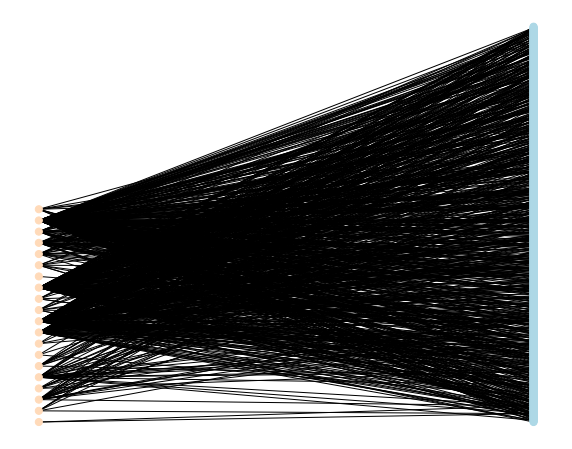

Users Nodes: 20, Hashtag Nodes: 707, Edges: 862


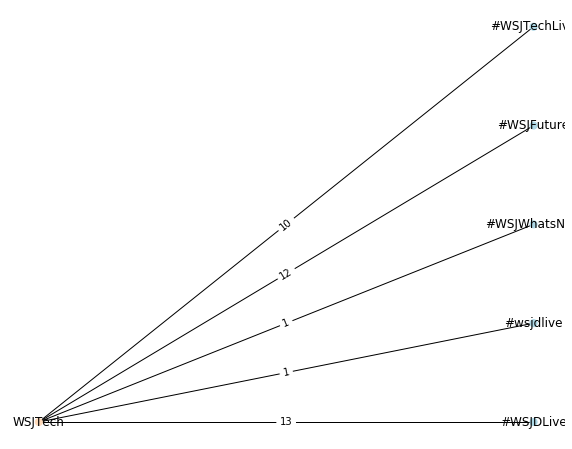

Users Nodes: 1, Hashtag Nodes: 5, Edges: 5


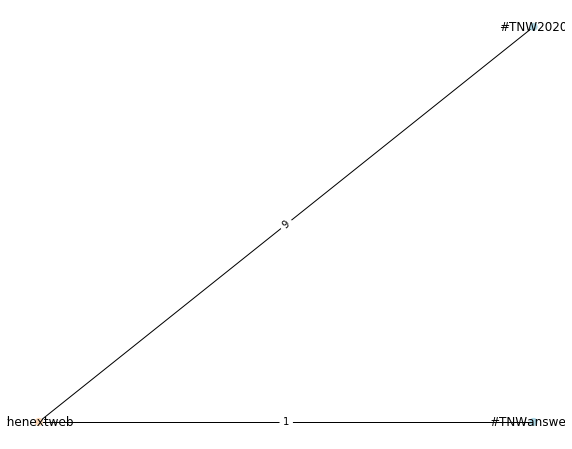

Users Nodes: 1, Hashtag Nodes: 2, Edges: 2


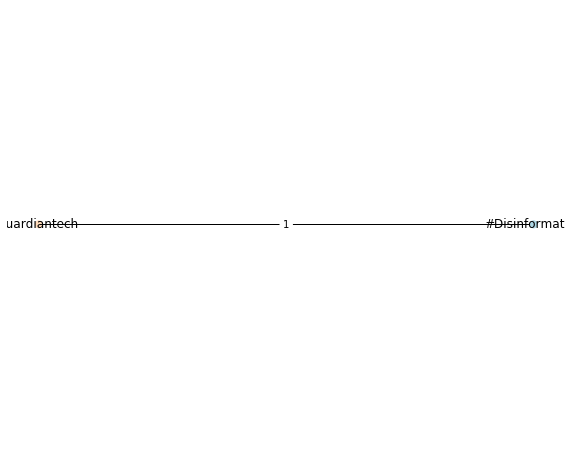

Users Nodes: 1, Hashtag Nodes: 1, Edges: 1


In [52]:
#Get Component Subgraphs
graphs = list(nx.connected_component_subgraphs(userHashtagG))

for graph in graphs:
    #Seperate Nodes into sets for each subgraph
    user_nodes = {n for n, d in graph.nodes(data=True) if d['bipartite']==0}
    hashtag_nodes = set(graph) - user_nodes
    
    #For each set, assign them different colours and position
    color_map, pos = {}, {}
    for i, node in enumerate(user_nodes):
        pos[node] = (0, i*500)
        color_map[node] = "#ffdab9"
    for i, node in enumerate(hashtag_nodes):
        pos[node] = (0.5, i*25)
        color_map[node] = "lightblue"
    colors = [color_map[node] for node in graph.nodes()]
    # draw the network    
    plt.figure(figsize=(10,8))
    
    # If our network is large we will not display the weights and labels
    # as this will clutter the drawing and make it unreadable
    if len(user_nodes) > 10:
        nx.draw_networkx(graph, pos=pos, with_labels=False, 
                node_size = 50,
                node_color = colors)
        plt.axis("off")
        plt.show()
        print("Users Nodes: %d, Hashtag Nodes: %d, Edges: %d" %  (len(user_nodes), len(hashtag_nodes), graph.number_of_edges()))
        
        bottom_nodes, top_nodes = bipartite.sets(graph)
        
    else:
        edgeLabels = nx.get_edge_attributes(graph,'weight')
        nx.draw_networkx(graph, pos=pos, with_labels=True, 
                node_size = 50,
                font_size = 12,
                node_color = colors)
        plt.axis("off")
        nx.draw_networkx_edge_labels(graph,pos=pos,edge_labels=edgeLabels)
        plt.show()
        
        print("Users Nodes: %d, Hashtag Nodes: %d, Edges: %d" %  (len(user_nodes), len(hashtag_nodes), graph.number_of_edges()))

From these sub graphs we can see that both WSJTech and thenextweb use hashtags which relate to their own network. For example all of WSJTech hashtags have WSJ at the start, which refer to other Wall Street Journal hashtags.

#### 5.2.2 Clustering

In [53]:
print("Cluserting of all Nodes")
getClustering(userHashtagG)
print("Cluserting of User Nodes")
getClustering(userHashtagG, userNodes)
print("Cluserting of Hashtag Nodes")
getClustering(userHashtagG, hashtagNodes)

Cluserting of all Nodes


clustering
#WSJWhatsNow         1.0
#WSJTechLive         1.0
#WSJDLive            1.0
#TNW2020             1.0
#wsjdlive            1.0

clustering
#Disinformation         0.0
guardiantech            0.0
thenextweb              0.0

Cluserting of User Nodes


clustering
technology       0.078
mashable         0.071
Gizmodo          0.070
verge            0.070
WIRED            0.061

clustering
guardiantech         0.0
thenextweb           0.0
WSJTech              0.0

Cluserting of Hashtag Nodes


clustering
#WSJFuture           1.0
#WSJDLive            1.0
#WSJWhatsNow         1.0
#TNWanswers          1.0
#TNW2020             1.0

clustering
#coronavirus          0.151
#MWC2020              0.143
#Disinformation       0.000

From our user clustering we can see that use technology has the highest clustering. From this you could suggest that this account uses the hashtags which are used more by other people, and thus its more likely for them to share hashtags and be in a cluster.

From looking at the clustering for our hashtag nodes we can see that the nodes with 100% clustering are the nodes from our small subgraphs. This makes sense as they are all connected by 1 node and thus their neighbour is connected to their neighbour. I'm curious to see which nodes have a higher cluster if we remove these small subgraphs, to do this I will get the clustering of our largest sub component.

In [54]:
bigG = max(nx.connected_component_subgraphs(userHashtagG), key=len)
user_nodes = {n for n, d in bigG.nodes(data=True) if d['bipartite']==0}
hashtag_nodes = set(bigG) - user_nodes

getClustering(userHashtagG, hashtag_nodes)

clustering
#CarVendingMachines          0.934
#Myst                        0.934
#DoomEternal                 0.934
#CybersecurityInHealth       0.934
#SXSW2020                    0.934

clustering
#GalaxyS20         0.162
#coronavirus       0.151
#MWC2020           0.143

The hashtags in the top 5 clustering are very different and don't seem to have a similar theme, and thus you can't suggest that they came from the same tweet (which would result in a high clustering) Therefore we can suggest that a group of users commonly used some of these hashtags in their tweets, thus forming a cluster and sharing similar tweet topics. 

#### 5.2.3 Degrees and Degree Distribution

In [55]:
#Weighted Degree for User Nodes
user_degree_weighted = pd.Series(dict(userHashtagG.degree(userNodes, weight="weight")), name="weighted_degree") 

print("User Nodes Weighted Degree")
displayDF(pd.DataFrame(user_degree_weighted), "weighted_degree")

#Weighted Degree for Hashtag Nodes
hashtag_degree_weighted = pd.Series(dict(userHashtagG.degree(hashtagNodes, weight="weight")), name="weighted_degree") 
print("Hashtag Nodes Weighted Degree")
displayDF(pd.DataFrame(hashtag_degree_weighted), "weighted_degree")

User Nodes Weighted Degree


weighted_degree
gigaom                    1462
RWW                        744
TelegraphTech              538
CNET                       129
arstechnica                123

weighted_degree
verge                       2
engadget                    1
guardiantech                1

Hashtag Nodes Weighted Degree


weighted_degree
#technology              124
#AI                      107
#CES2020                  97
#Apple                    86
#Podcast                  79

weighted_degree
#databreaches                1
#MassEffect2                 1
#Heathrow                    1

From our weighted degrees we can see that gigaom is again the most active user and has used the most amount of hashtags. They used nearly twice as many hashtags as the 2nd highest user. This again shows how active gigaom, and thus they have a high impact in our network.

For the hashtags, possibly unsurprisingly for our technology twitter list the most common hashtag is technology. Which shows that the most talk topic is technology. The second most used hashtag is AI, which express how popular this buzz term is in the tech industry.

Using unweighted degrees can show which users post a wider range of hashtags, and which hashtags are used by a wider range of people.

In [56]:
#Degree for User Nodes
user_degree = pd.Series(dict(userHashtagG.degree(userNodes)), name="degree") 

print("User Nodes Degree")
displayDF(pd.DataFrame(user_degree), "degree")

#Degree for Hashtag Nodes
hashtag_degree = pd.Series(dict(userHashtagG.degree(hashtagNodes)), name="degree") 
print("Hashtag Nodes Degree")
displayDF(pd.DataFrame(hashtag_degree), "degree")

User Nodes Degree


degree
RWW               259
gigaom            192
TelegraphTech     138
arstechnica        74
TechRepublic       41

degree
verge              2
engadget           1
guardiantech       1

Hashtag Nodes Degree


degree
#coronavirus       7
#GalaxyS20         7
#MWC2020           7
#5G                6
#CES2020           6

degree
#googleapps       1
#Alienware        1
#Heathrow         1

From our unweighted degrees we can see that RWW posted the most different hashtags, which meant that gigaom spammed 192 hashtags on average 7.6 times.

Interestingly for our hashtag network technology or AI are not even in our top 5, which suggest that the same users were spamming these hashtags instead of many users using the technology or AI hashtag. GalaxyS20, MWC2020 and coronavirus are mentioned by 7 different users from our member list. These show the major topic modern topics, as they have the highest non-weighted degree in our network.

Nodes Degree vs Hashtag Degree


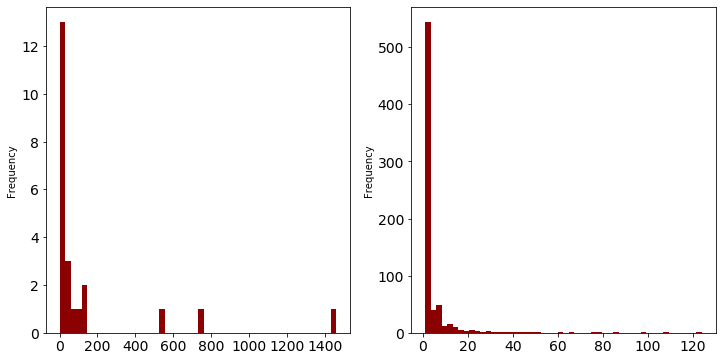

In [57]:
fig, axs = plt.subplots(1,2)
print("Nodes Degree vs Hashtag Degree")
df = user_degree_weighted.plot.hist(figsize=(12,6), fontsize=14, legend=None, color="darkred", bins=50, zorder=3, ax=axs[0]) 
df = hashtag_degree_weighted.plot.hist(figsize=(12,6), fontsize=14, legend=None, color="darkred", bins=50, zorder=3, ax=axs[1])

From these two degree distributions we can see that they again have the distribution we would expect from a social network. We can also see the effect of gigaom's spamming as it has greatly widened our distribution. Looking at out hashtag distribution we can see that a majority of hashtags were used only a little (around <10) which means that our list member use a variety of hashtags and thus discuss a variety of topics.

#### 5.2.4 Centrality
As out network is not connected and therefore our centrality functions do not work, therefore I will instead analyse our biggest connected sub-graph. This should not affect the overall results too much as the other subgraphs were very small. 

In [58]:
userHashtag_cent = getCentrality(bigG, nodes=user_nodes)

Sorted by degree centrality


degree_centrality  betweenness_centrality  closeness_centrality
RWW                       0.366                   0.542                 0.415
#GalaxyS20                0.350                   0.055                 0.720
#MWC2020                  0.350                   0.015                 0.570
#coronavirus              0.350                   0.089                 0.609
#CES2020                  0.300                   0.018                 0.581

degree_centrality  betweenness_centrality  closeness_centrality
mashable              0.004               2.757e-03                 0.191
verge                 0.003               1.524e-04                 0.244
engadget              0.001               0.000e+00                 0.215

Sorted by betweenness centrality


degree_centrality  betweenness_centrality  closeness_centrality
RWW                        0.366                   0.542                 0.415
gigaom                     0.272                   0.410                 0.368
TelegraphTech              0.195                   0.363                 0.392
arstechnica                0.105                   0.176                 0.261
TechRepublic               0.058                   0.096                 0.356

degree_centrality  betweenness_centrality  \
#NVMe                              0.05                     0.0   
#NationalDayofPrayer               0.05                     0.0   
#TalkingTech                       0.05                     0.0   

                      closeness_centrality  
#NVMe                                0.521  
#NationalDayofPrayer                 0.497  
#TalkingTech                         0.497

Sorted by closeness centrality


degree_centrality  betweenness_centrality  \
#5G                                   0.30                   0.072   
#cloud                                0.20                   0.035   
#ArtificialIntelligence               0.20                   0.035   
#Microsoft                            0.15                   0.028   
#IoT                                  0.15                   0.028   

                         closeness_centrality  
#5G                                     0.828  
#cloud                                  0.806  
#ArtificialIntelligence                 0.806  
#Microsoft                              0.787  
#IoT                                    0.787

degree_centrality  betweenness_centrality  closeness_centrality
TechCrunch              0.010                   0.014                 0.233
engadget                0.001                   0.000                 0.215
mashable                0.004                   0.003                 0.191

The user RWW has the highest degree centrality along with the highest betweenness centrality score, this means that RWW is on the shortest path the most for paths on our network. Due to this you can say that RWW is a bridging node, or broker node in our UserHashtag network. From this you can therefore suggest that RWW has a big influence on the network, and the tech industry.

When we look at closeness centrality, #5G has the largest closeness which means they are closest to all other nodes in the network. From this you could propose that this hashtag was mention along with a lot of other hashtags or was used frequently by users who had a lot of connections. This shows that 5G is an important topic, and thus it talked about a lot in the technology twitter space.

## 6.0 Hashtag co-occurrence network
While our User-Hashtag network observed the relationship between users and hashtags. Our Hashtag co-occurrence network will express the relationship between the hashtags themselves, and which hashtags are posted together. This will allow us to deduce which themes/topics are related, and popular.

### 6.1 Construction
For every hashtag in a tweet we need to pair them up, and create an edge between them, as they are connected by being in the same tweet. This paring relationship is nondirectional and can be repeated. Therefore we will create an undirected weighted network.

C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<Figure size 1440x720 with 0 Axes>

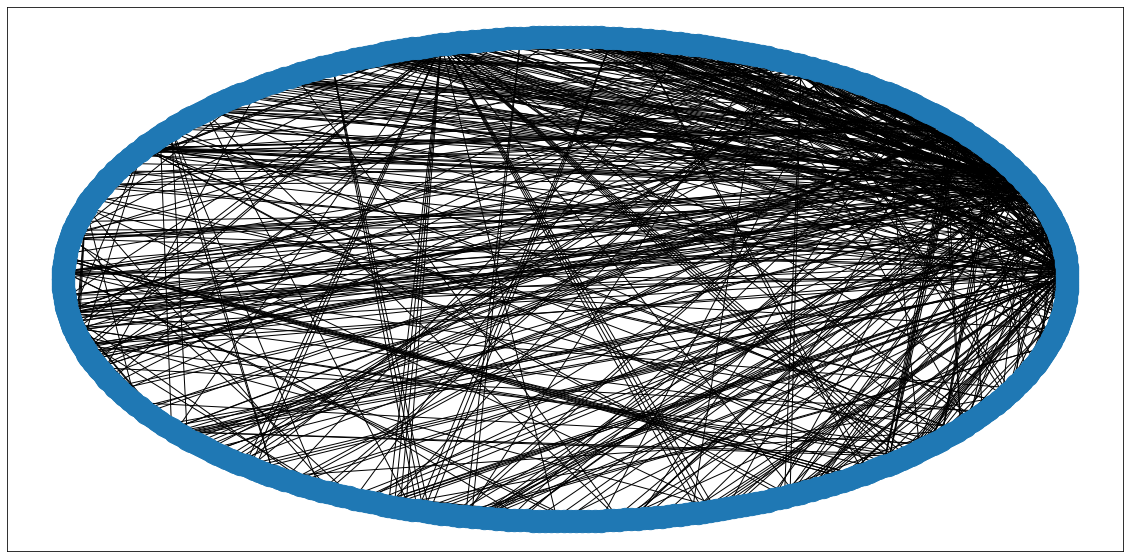

Nodes: 511, Edges: 1058


In [59]:
hashtagCooccurrenceG = nx.Graph()

for tweet in tweet_list:
    #Gather hashtag data
    data = json.loads( tweet )
    hashtags = data["entities"]["hashtags"] 
    #Can't have co-occurrence of tweets with 1 hashtag 
    if len(hashtags) > 1:
        #Group the hashtags from the tweet into 1 list
        hashtagList = []
        for hashtag in hashtags:
            tag = hashtag["text"]
            hashtagList.append(tag)
        #Pair up all hashtags
        for pair in itertools.combinations(hashtagList,2):
            #Add edges and weights
            if hashtagCooccurrenceG.has_edge(*pair):
                hashtagCooccurrenceG[pair[0]][pair[1]]["weight"] += 1
            else:
                hashtagCooccurrenceG.add_edge(*pair, weight = 1)

displayNetwork(hashtagCooccurrenceG)

### 6.2 Characterisation 

#### 6.2.1 Structure

In [60]:
getStructure(hashtagCooccurrenceG)

Network's Density: 0.01
Network is not connected, there are 50 components.


From this we can see we have a very disconnected network. To get a better understanding of the connection between hashtags I will look at the biggest 6 connected subgraphs of our co-occurrence network.

Graph 1


<Figure size 720x360 with 0 Axes>

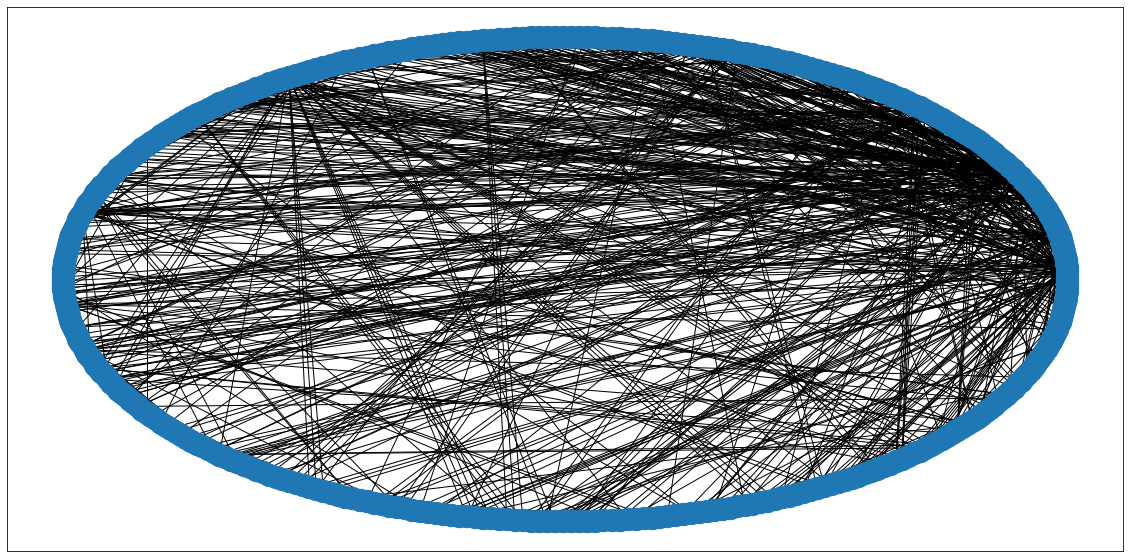

Nodes: 391, Edges: 965
Graph 2


<Figure size 720x360 with 0 Axes>

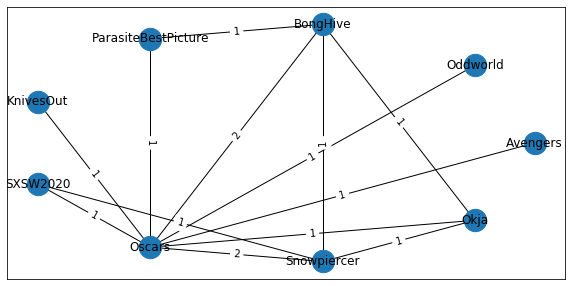

Nodes: 9, Edges: 13
Graph 3


<Figure size 720x360 with 0 Axes>

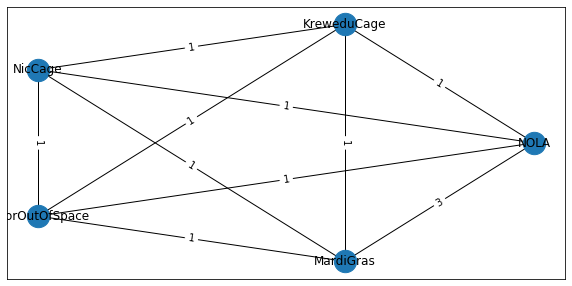

Nodes: 5, Edges: 10
Graph 4


<Figure size 720x360 with 0 Axes>

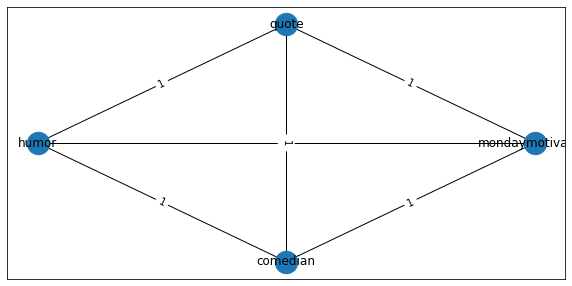

Nodes: 4, Edges: 6
Graph 5


<Figure size 720x360 with 0 Axes>

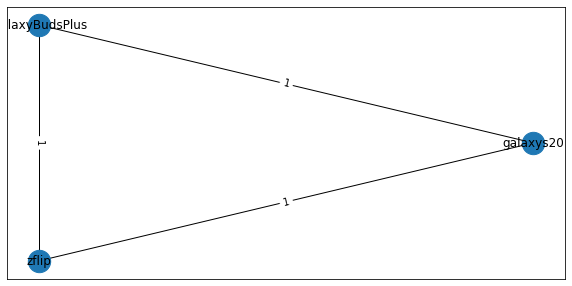

Nodes: 3, Edges: 3
Graph 6


<Figure size 720x360 with 0 Axes>

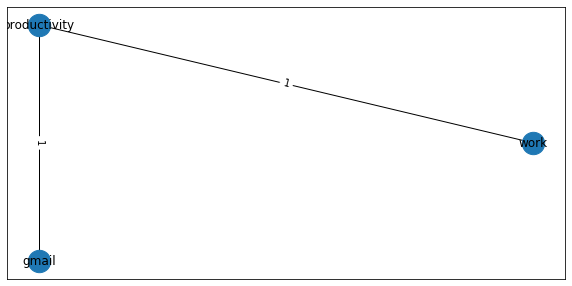

Nodes: 3, Edges: 2


In [61]:
#Count to limit the amount of graphs we draw
count = 1
#Gather largest subraphs
for graph in sorted(nx.connected_component_subgraphs(hashtagCooccurrenceG), key=len, reverse=True):
    print("Graph", count)
    displayNetwork(graph, sizeX= 10, sizeY=5)
    count+=1
    if count > 6:
        break

If we look at graphs 3 to 5 they have total connectivity, as we have all possible edges. It means there was a tweet which included all those hashtags. For networks in which all of weights are 1 (like graph 4), it shows that these hashtags were only used once, and only by this 1 tweet.

Graph 2 seems to be a graph with a common theme of movies, and thus they don't seem to have any connection to technology twitter network, which is why they are disconnected from our main network.

Lets look at graph 4 nodes to see who posted this tweet.

In [62]:
print(list(userHashtagG.edges('#humor'))[0][1], "posted the tweet with #humor")

gigaom posted the tweet with #humor


Gigaom having a single tweet with 4 different hashtags could explain why they have such a high degree and influence on the network, and possibly that a lot of their tweets follow this similar mass spamming of multiple hashtags. This could be done to ‘game’ on the twitter hashtag system, as if your tweets has more relevant hashtags it is more likely to get shown in search results.

#### 6.2.2 Clustering

In [63]:
getClustering(hashtagCooccurrenceG)

clustering
Davos2020             1.0
NetAppInsight         1.0
CEM                   1.0
insurance             1.0
SIEMs                 1.0

clustering
VR                0.0
marketing         0.0
Capcom            0.0

These hashtags with a clustering of 1.0 could just be one of the nodes in our connected subgraphs, and thus are 100% clustered due a small set of nodes connected to the hashtag, or there it just the one node. Therefore let’s look at the clustering of the biggest connected subgraph.

In [64]:
bigG2 = max(nx.connected_component_subgraphs(hashtagCooccurrenceG), key=len)
getClustering(bigG2)

clustering
hollywood                   1.0
internetpeering             1.0
IDtheft                     1.0
databreaches                1.0
selfdrivingvehicles         1.0

clustering
goals              0.0
galaxyfold         0.0
Capcom             0.0

Interestingly we still have nodes in our network with 100% clustering, which means that we have groups of hashtags which are in similar tweets. These nodes with high clustering will form triangles, which are nodes who neighbours share edges. We can use a triangles function to see which nodes have the most triangles.

In [65]:
triangles = pd.Series(dict(nx.triangles(hashtagCooccurrenceG)), name="triangles")
displayDF(pd.DataFrame(triangles), "triangles")

triangles
AI             144
cloud          116
data           109
Podcast         90
podcast         82

triangles
VR                 0
marketing          0
Capcom             0

From this we can see that AI has the most triangles within the network. We can create an ego-centric network from this AI node as our focus node. The subnetwork is simply a graph made up of the focus node and its neighbours. Its edges only consist of the connections between the neighbours and the focus node. From this ego subnetwork I hope to see these triangles

C:\Users\Susie\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


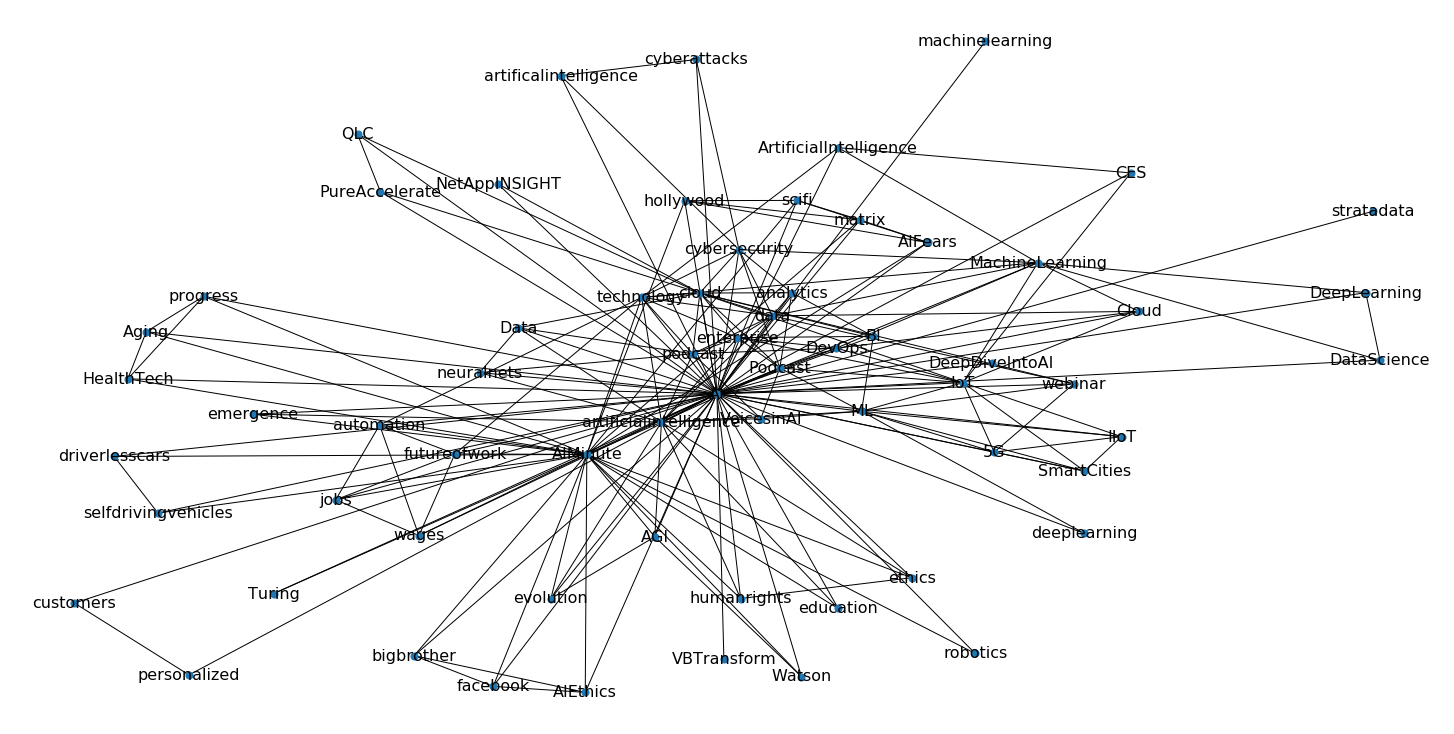

In [66]:
ego1 = nx.ego_graph( hashtagCooccurrenceG, "AI" )
plt.figure(figsize=(20,10))
nx.draw(ego1, with_labels=True, node_size = 50, font_size=16)
pos=nx.shell_layout(ego1)

By looking at the triangles we are able to identify important subjects and themes from our network. For example we can see that there are triangles between AI, AIEthics, facebook and bigbrother. These could be related to the Cambridge Analytica scandal, and thus shows the importance that AI had in the subject. The triangles also show technologies in which AI has been used, for example we have a triangle of driverless cars, and self driving vehicles. 

By identifying these important technologies we are able to see how AI has had an major influence on the technology industry as its involved with new systems. We can also see the difference in opinions about AI, for example we can see AIfears and human rights. This shows as even though we are seeing great technological advancement with AI, there are opposing opinions being discussed in terms of the ethics and the resulting factors that come along with AI.

From looking at the triangles of the AI ego centric network we are able to understands the key topics and views of AI, and such we are possibly able to represent societies perception of AI by analysing these hashtag relations. Perhaps if we look at a non-technology based twitter list we could see a more general societal view of AI.

#### 6.2.3 Degree Centrality and Degree Distribution

In [67]:
coocurr_degree = getDegreeCent(hashtagCooccurrenceG)

degree_centrality_weighted
Podcast                       0.042
AI                            0.038
cloud                         0.035
data                          0.035
podcast                       0.034

degree_centrality_weighted
deals                    1.516e-04
Adobe                    1.516e-04
Capcom                   1.516e-04

From this we can see that podcast has the highest weighted degree, this shows that podcast was used frequently with other hashtags multiple times. This makes sense as if you were to post about your podcast, you would also post hashtags which describe the theme/topics of your podcast, and thus we would have a high amount of pairing of podcast to the themes/topics. From this we can also deduce that podcast are a popular and important form of media for the technology sector. It would be interesting to analyse past tweets to see if podcasts would still be high in popularity, or if it’s a new form of media which is being utilised by our technology news twitter accounts.

However this is the weighted degree, which shows the repeated popularity of hashtags parings. To show hashtags which have a wider variety of themes (hashtags) connected them we can use non-weighted degree)

In [68]:
degree_cent = pd.Series(dict(nx.degree_centrality(hashtagCooccurrenceG)), name="degree_centrality")
displayDF(pd.DataFrame(degree_cent), "degree_centrality")  

degree_centrality
AI                      0.129
technology              0.125
cloud                   0.088
data                    0.084
Podcast                 0.071

degree_centrality
ICLR                0.002
ICML                0.002
Capcom              0.002

By looking at the unweighted degrees we can see that AI has been used with a higher variety of other hashtags. This means that AI is involved in many other topics within our technology space, and thus again shows the importance of AI in our modern technology. It also express how AI has become an 'buzz word', and thus its popular to mention it.

By comparing both the weighted vs unweighted degrees we are able to see which topics are popular with other topics in our network (AI), and which topics are popular to mention repeatedly with other topics (podcast).

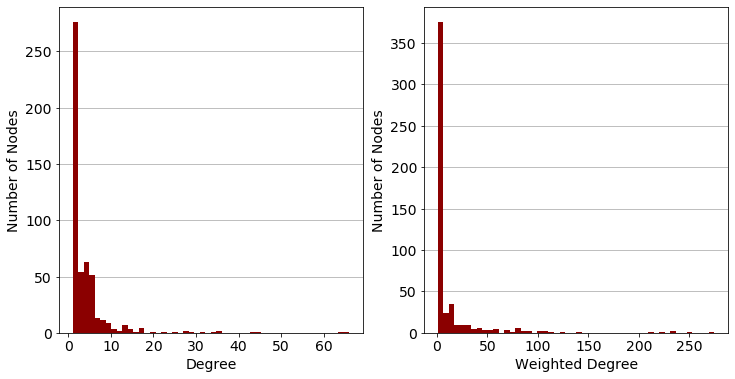

In [69]:
getDegreeDistribution(hashtagCooccurrenceG)

Our distribution of hashtag co-occurrence network is again the right skewed exponential distribution that we would expect from a social network. This shows for both our weighted and non-weighted degrees, that we have a lot of nodes with a small amount of connections (common hashtag occurrences), and only a small amount of nodes with a high amount of common occurrences like AI.

#### 6.2.4 Centrality

In [70]:
coocurr_cent = getCentrality(hashtagCooccurrenceG)

Sorted by eigenvector centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
AI                        0.355                            0.247   
cloud                     0.276                            0.232   
data                      0.262                            0.340   
Podcast                   0.229                            0.257   
podcast                   0.227                            0.327   

         betweenness_centrality  closeness_centrality  
AI                        0.132                 0.322  
cloud                     0.082                 0.313  
data                      0.061                 0.301  
Podcast                   0.031                 0.274  
podcast                   0.025                 0.293

eigenvector_centrality  eigenvector_centrality_weighted  \
holidays                        2.263e-21                        1.131e-39   
review                          2.263e-21                        1.131e-39   
cleanyourcomputer               2.263e-21                        1.131e-39   

                   betweenness_centrality  closeness_centrality  
holidays                              0.0                 0.002  
review                                0.0                 0.002  
cleanyourcomputer                     0.0                 0.002

Sorted by weighted eigenvector centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
data                         0.262                            0.340   
enterprise                   0.218                            0.337   
podcast                      0.227                            0.327   
Podcast                      0.229                            0.257   
AI                           0.355                            0.247   

            betweenness_centrality  closeness_centrality  
data                         0.061                 0.301  
enterprise                   0.036                 0.293  
podcast                      0.025                 0.293  
Podcast                      0.031                 0.274  
AI                           0.132                 0.322

eigenvector_centrality  eigenvector_centrality_weighted  \
Ford                        2.263e-21                        1.131e-39   
innovate                    2.263e-21                        1.131e-39   
ValentinesDay               2.263e-21                        1.131e-39   

               betweenness_centrality  closeness_centrality  
Ford                              0.0                 0.002  
innovate                          0.0                 0.002  
ValentinesDay                     0.0                 0.002

Sorted by betweenness centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
technology                   0.216                            0.065   
AI                           0.355                            0.247   
Apple                        0.054                            0.004   
cloud                        0.276                            0.232   
Google                       0.062                            0.003   

            betweenness_centrality  closeness_centrality  
technology                   0.190                 0.330  
AI                           0.132                 0.322  
Apple                        0.099                 0.291  
cloud                        0.082                 0.313  
Google                       0.076                 0.288

eigenvector_centrality  eigenvector_centrality_weighted  \
NRF2020                    0.040                        2.730e-03   
funfacts                   0.022                        6.403e-03   
Capcom                     0.002                        6.093e-06   

          betweenness_centrality  closeness_centrality  
NRF2020                      0.0                 0.240  
funfacts                     0.0                 0.218  
Capcom                       0.0                 0.189

Sorted by closeness centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
technology                   0.216                            0.065   
AI                           0.355                            0.247   
cloud                        0.276                            0.232   
data                         0.262                            0.340   
podcast                      0.227                            0.327   

            betweenness_centrality  closeness_centrality  
technology                   0.190                 0.330  
AI                           0.132                 0.322  
cloud                        0.082                 0.313  
data                         0.061                 0.301  
podcast                      0.025                 0.293

eigenvector_centrality  eigenvector_centrality_weighted  \
chromebook                  2.263e-21                        1.131e-39   
ValentinesDay               2.263e-21                        1.131e-39   
outdoors                    2.263e-21                        1.131e-39   

               betweenness_centrality  closeness_centrality  
chromebook                        0.0                 0.002  
ValentinesDay                     0.0                 0.002  
outdoors                          0.0                 0.002

Technology is the highest in terms of closeness and betweenness centrality, which means that technology is close to many of the other nodes in our network, and is on the shortest path for many of the nodes. This means that the hashtag technology has a major influence on the network as it controls the flow of information, as it’s a bridging or broker node (betweenness), and its able to collect information quickly as its close to many nodes (closeness). It makes sense that technology would be an influential topic in our technology twitter list, as it’s the theme that connects all twitter users in our list.

By looking at our at non-weighted eigenvectors AI is the highest, this means that AI is a very important node as it is connected to other important nodes. From before we have proved that AI is connected to many other nodes in our network, and thus has a high influence as its connected so many topics/hashtags in our network.

However by looking at the weighted eigenvector centrality, we can see that data in the lead. This can suggest that while AI is connected to a high variety of influential nodes. Data is connected repeatedly to important nodes, and thus is an influential node.

From looking at the triangles, degree and centrality dataframes we can see that we have a user error in our network. We have duplication of both Podcast and podcast. This user error can possibly be effecting our results as we have multiple different hashtags representing the same idea. To explore this change I will make a new hashtag cooccurrence network, however I will change each hashtag into lowercase.

In [71]:
hashtagCooccurrenceGLOWERCASE = nx.Graph()

for tweet in tweet_list:
    #Gather hashtag data
    data = json.loads( tweet )
    hashtags = data["entities"]["hashtags"] 
    #Can't have co-occurrence of tweets with 1 hashtag 
    if len(hashtags) > 1:
        #Group the hashtags from the tweet into 1 list
        hashtagList = []
        for hashtag in hashtags:
            tag = hashtag["text"].lower()
            hashtagList.append(tag)
        #Pair up all hashtags
        for pair in itertools.combinations(hashtagList,2):
            #Add edges and weights
            if hashtagCooccurrenceGLOWERCASE.has_edge(*pair):
                hashtagCooccurrenceGLOWERCASE[pair[0]][pair[1]]["weight"] += 1
            else:
                hashtagCooccurrenceGLOWERCASE.add_edge(*pair, weight = 1)

print("Nodes: %d, Edges: %d" %  (hashtagCooccurrenceGLOWERCASE.number_of_nodes(), hashtagCooccurrenceGLOWERCASE.number_of_edges()))

print("Change in Nodes: %d" %  (hashtagCooccurrenceG.number_of_nodes() - hashtagCooccurrenceGLOWERCASE.number_of_nodes()))

Nodes: 463, Edges: 990
Change in Nodes: 48


We had 48 different hashtags were simply a variant of another hashtag, this shows how much human error there can be in a dataset. Lets take a quick look at the degree and centrality changes to see if these errors effected our network.

In [72]:
lowercase_degree = getDegreeCent(hashtagCooccurrenceGLOWERCASE)
lowercase_cent = getCentrality(hashtagCooccurrenceGLOWERCASE)

degree_centrality_weighted
podcast                          0.076
cloud                            0.042
ai                               0.040
data                             0.039
enterprise                       0.036

degree_centrality_weighted
lockpicking                   1.516e-04
locksport                     1.516e-04
capcom                        1.516e-04

Sorted by eigenvector centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
ai                           0.315                            0.246   
podcast                      0.300                            0.514   
cloud                        0.297                            0.259   
data                         0.260                            0.297   
technology                   0.223                            0.065   

            betweenness_centrality  closeness_centrality  
ai                           0.129                 0.347  
podcast                      0.052                 0.319  
cloud                        0.063                 0.328  
data                         0.055                 0.319  
technology                   0.174                 0.346

eigenvector_centrality  eigenvector_centrality_weighted  \
worklifebalance               8.848e-21                        2.392e-25   
outdoors                      8.848e-21                        2.392e-25   
reutersdavos                  8.848e-21                        4.656e-23   

                 betweenness_centrality  closeness_centrality  
worklifebalance                     0.0                 0.002  
outdoors                            0.0                 0.002  
reutersdavos                        0.0                 0.002

Sorted by weighted eigenvector centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
podcast                      0.300                            0.514   
data                         0.260                            0.297   
enterprise                   0.210                            0.273   
cloud                        0.297                            0.259   
ai                           0.315                            0.246   

            betweenness_centrality  closeness_centrality  
podcast                      0.052                 0.319  
data                         0.055                 0.319  
enterprise                   0.035                 0.309  
cloud                        0.063                 0.328  
ai                           0.129                 0.347

eigenvector_centrality  eigenvector_centrality_weighted  \
predatorpax               8.848e-21                        2.392e-25   
space                     8.848e-21                        2.392e-25   
music                     8.848e-21                        2.392e-25   

             betweenness_centrality  closeness_centrality  
predatorpax                     0.0                 0.002  
space                           0.0                 0.002  
music                           0.0                 0.002

Sorted by betweenness centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
technology                   0.223                            0.065   
ai                           0.315                            0.246   
apple                        0.080                            0.005   
cloud                        0.297                            0.259   
5g                           0.069                            0.015   

            betweenness_centrality  closeness_centrality  
technology                   0.174                 0.346  
ai                           0.129                 0.347  
apple                        0.100                 0.309  
cloud                        0.063                 0.328  
5g                           0.063                 0.287

eigenvector_centrality  eigenvector_centrality_weighted  \
backtowork                    8.848e-21                        2.392e-25   
worklifebalance               8.848e-21                        2.392e-25   
capcom                        1.622e-03                        3.953e-06   

                 betweenness_centrality  closeness_centrality  
backtowork                          0.0                 0.002  
worklifebalance                     0.0                 0.002  
capcom                              0.0                 0.193

Sorted by closeness centrality


eigenvector_centrality  eigenvector_centrality_weighted  \
ai                           0.315                            0.246   
technology                   0.223                            0.065   
cloud                        0.297                            0.259   
data                         0.260                            0.297   
podcast                      0.300                            0.514   

            betweenness_centrality  closeness_centrality  
ai                           0.129                 0.347  
technology                   0.174                 0.346  
cloud                        0.063                 0.328  
data                         0.055                 0.319  
podcast                      0.052                 0.319

eigenvector_centrality  eigenvector_centrality_weighted  \
spacex                  8.848e-21                        2.392e-25   
clonewars               8.848e-21                        2.392e-25   
vegan                   8.848e-21                        2.392e-25   

           betweenness_centrality  closeness_centrality  
spacex                        0.0                 0.002  
clonewars                     0.0                 0.002  
vegan                         0.0                 0.002

By comparing our networks we can see that podcast now has the highest eigenvector centrality, and thus by removing these duplicates it has shown that podcast was in fact connected to more important nodes than ai was. However also due to this change ai is now the highest closeness, which suggest that we also had both AI and ai hashtag, with AI being more popular.

This shows the effect that human error has on a dataset, and how as data scientists we need to be able to identify these errors and change them. There is also many difference string variance within these hashtags, for example ai vs artificial intelligence. Which might need to be looked into for further studies. 

However there is also some discussion into whether or not we should normalise the data, as these invariances and errors truly represent the human’s topics and responses. Therefore if we were to remove these variations, some information can be lost. We could further look into which variant is more popular, and possibly try to understand why. It also shows how there is no uniformity enforced in twitter, and such we have these variances of data. For the sake of analyses and consistency in discussions, should consistent hashtags be enforced?

However we have shown that AI is a major influence in modern technology, and how it’s connected to major technology and topics in our network. We have also shown that podcast are a popular form of media, and thus have a high influence reporting of news and information.

## 6.0 Conclusion
To conclude we have shown that our twitter technology list aren’t very connected. Only 22% follow each other and we only had 1 reply between 2 members. However we have shown that the twitter account show an importance in self-replying to their own posts. Although through the mention network we showed that our list members mentioned a large variety of different users, with some accounts mentioning each other, with the strongest relationship being TechRepublic and ZDNet. Our twitter list included a majority of news accounts, and they tended to mention reporters like Ed Bott and Zoe Kleinman. This expressed an employer to employee relationship within our network, and how information is passed around. 

Along with analysing the members of our list, we delved into the topics they discussed by looking into their hashtags. From this we could see that AI is a major technology in our system, and thus is reported tweeted a lot. We also found that podcast seemed to be the current preferred method of information sharing. By looking at the hashtags themselves we were able to see clusters of themes and opinions of a topic, which allows us to fully explore the major topics of modern society. For further studies it would be interesting to compare different twitter lists, or the general public’s opinions on popular topics to see if we have any difference of opinions or ideas highlighted. It would also be good to extend our networks and tweet collection to include the tweets of any account mention/replied by our members list. Doing this will allow us to better explore the interrelations between the technology twitter space.